# Portafolios con el Modelo Black & Litterman y expectativas con RNN-LSTM

La siguiente libreta Jupyter tiene el objetivo plantear la construcción de 4 portafolios bajo la metodología de **Black & Litterman**. La diferencia de los portafolios radica en la consideración de diferentes expectativas para el Modelo Black & Litterman con base en estadísticas y una con Redes Neuronales. La hipótesis que pretende resolver este trabajo es que el uso de la Inteligencia Aritificial, en este caso Redes Neuronales, permite la obtención de portafolios más eficientes en términos de rendimiento y riesgo, consdierando la metodología Black & Litterman.

***Portafolio 1:** Expectativas construidas por medio de la media del crecimiento de las ganancias por acción un año previo a la decisión de construir el portafolio.

***Portafolio 2:** Expectativas considerando la mediana de crecimiento de las ganancias por acción un año previo a la decisión de construir el portafolio.

***Portafolio 3 (de Oro):** Expectativas considerando el conocimiento completo de cuanto creceran las acciones durante un año (como si fuera un oraculo). Este portafolio será base para comparación con el de Redes Neuronales, porque nos diría el portafolio óptimo si se tuviera pleno conocimiento de la información futura. 

***Portafolio 4:** Expectativas construidas por medio de Redes Neuronales Recurrentes (RNN) de tipo Long-Short Term Memory (LSTM). 

Los modelos Black & Litterman se desarrollarán con base en PyPortfolioOpt

*Capítulo 1. Marco Teórico del Modelo Black & Litterman*

*Capítulo 2. Ingeniería de Datos*

*Capítulo 3. Modelos Propuestos - Aplicación Modelo BL*

*Capítulo 4. Resultados*

*Capítulo 5. Conclusiones*

### Capítulo 1. Marco Teórico del Modelo Black & Litterman

#### Ecuación General del Modelo B&L 

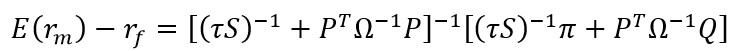

El Modelo Black & Litterman se reduce a un vector donde se trata el rendimiento esperado como una cantidad a ser estimada, en en relación a variables que consideran el riesgo de los activos, el riesgo del mercado, los rendimientos de los activos previos a la estructuración del portafolio, las expectativas del inversionista, el riesgo de estas y su confianza en las mismas.

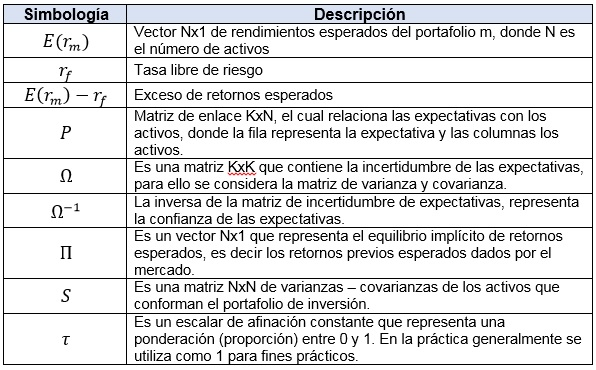

#### Grado de Aversión al Riesgo del Inversionista 

El modelo asume que un inversionista tiene una función de utilidad donde considera el rendimiento esperado de los activos y la diferencia de un nivel de riesgo que está dispuesto asumir. Esto se puede describir de la siguiente manera:

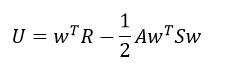

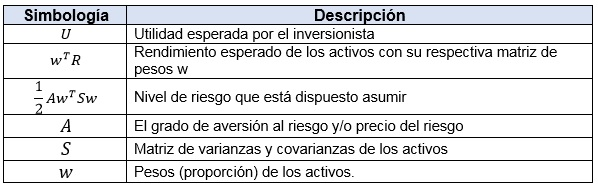

Ante esto, el **Grado de Aversión al Riesgo (A)** se puede expresar de la siguiente manera

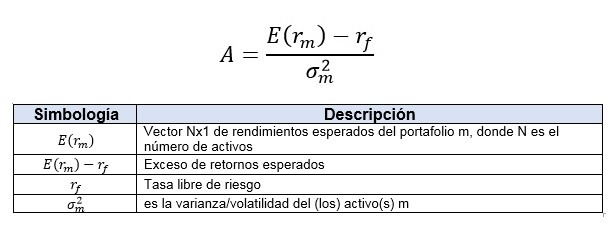

### Capítulo 2. Ingeniería de Datos

### Descripción General

Se realizará el análisis diario de los precios de cierre de los activos, con un periodo de 10 años, del 1 de enero de 2008 al 31 de enero de 2018. Se asumirá que el portafolio se elige el 31 de diciembre de 2018 y se evaluará para el periodo un año de manera mensual del 1 de enero al 31 de diciembre de 2019.  

Para la estructuración de los modelos se considerarán acciones de empresas y bonos que coticen en la bolsa de valores New York Stock Exchange (NYSE) y NASDAQ de Estados Unidos. Con el fin de lograr diversificación imparcial en el portafolio, se consideraron inicialmente un total de 20 activos de riesgo: 18 acciones de empresas y 2 bonos seleccionados aleatoriamente. Para la selección de activos de las empresas, se contextualiza el día 31 de diciembre de 2018, que es la fecha que se armará el portafolio de inversión. Para ese día se seleccionaron 5 acciones de empresa con Mega capitalización de mercado y capitalización de mercado grande; se seleccionaron aleatoriamente 2 empresas de capitalización mercado pequeña y mediana, 1 de capitalización de mercado micro y 3 de capitalización de mercado nano. 

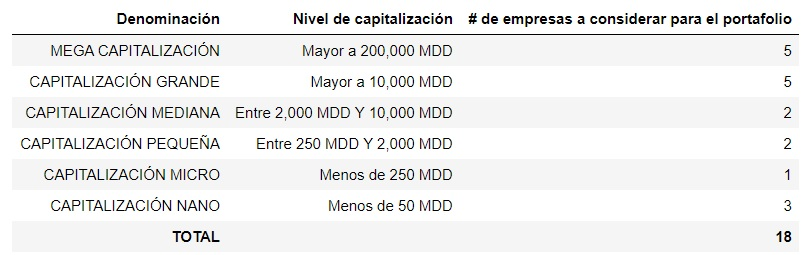

No obstante, al final, se descartaron 6 activos al no contar confirmación completa, dado que es necesaria el mismo número de datos para la aplicación de Redes Neuronales, quedando un total 14 activos de riesgo.

Finalmente, se considera como tasa libre de riesgo el Bono del Tesoro de 13 semanas de Estados Unidos con un rendimiento del 2.3834% al 28 de diciembre de 2018 (última cotización de 2018) y como rendimiento de mercado se considera el precio ajustado, para el mismo periodo de análisis, del índice de S&P500 (SPY). 

#### Importación de Paqueterías

In [1]:
from pyfmpcloud import settings
from pyfmpcloud import stock_time_series as sts
from pyfmpcloud import company_valuation as cv

In [2]:
import numpy as np
import finta as ta
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import time
import requests
import io
import json
import pyfolio as pf
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

C:\Users\alanf\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


#### Datos: Activos de Riesgo

In [3]:
## LECTURA DE CSV DE LISTA DE EMPRESAS Y BONOS QUE SE UTILIZARAN EN EL MODELO ##
list_names_csv = pd.read_csv("list_names_VF.csv")
list_names = pd.DataFrame(list_names_csv)
list_names = list_names.set_index('symbol')
list_names

,name
symbol,
AAPL,Apple Inc
AME,AMETEK Inc
BAC,Bank of America Corp
CNP,CenterPoint Energy Inc
CNS,Cohen & Steers Inc
EXPE,Expedia Group Inc
FTEK,Fuel Tech Inc
INTC,Intel Corp
KEY,KeyCorp


#### Datos: Capitalización del Mercado

In [4]:
## LECTURA DE CSV ##
list_mcaps_csv = pd.read_csv("list_mcaps_VF.csv")
list_mcaps = pd.DataFrame(list_mcaps_csv)

tickers = list_mcaps['symbol'].values
tickers = tickers.tolist()

mcaps = dict(list_mcaps.values)

list_mcaps

#mcaps

,symbol,mcap
0,AAPL,745725159960
1,AME,15436984550
2,BAC,243751221000
3,CNP,14155064000
4,CNS,1630724900
5,EXPE,17145761760
6,FTEK,29729100
7,INTC,215985000000
8,KEY,15052390800
9,MSFT,779829520000


In [5]:
tickers

['AAPL',
 'AME',
 'BAC',
 'CNP',
 'CNS',
 'EXPE',
 'FTEK',
 'INTC',
 'KEY',
 'MSFT',
 'PACW',
 'PAYX',
 'SCD',
 'SCX']

#### Datos: Precios de Cierre (Actualizados al 23 de marzo de 2021)

In [6]:
close_prices_csv = pd.read_csv("close_prices_model_VF.csv")
close_prices = pd.DataFrame(close_prices_csv)
close_prices['date'] = pd.to_datetime(close_prices['date'])
close_prices = close_prices.set_index('date')
close_prices

,AAPL,AME,BAC,BBN,CFMS,CNP,CNS,ELU,EXPE,FB,FLOW,FTEK,INTC,KEY,MSFT,PACW,PAYX,PRAH,SCD,SCX
date,,,,,,,,,,,,,,,,,,,,
2008-01-02,6.958571,20.475555,40.560001,0.000000,0.00,16.870001,28.760000,0.0,61.099998,0.000000,0.000000,22.52,25.350000,22.799999,35.220001,40.299999,34.990002,0.000000,17.680000,12.3772
2008-01-03,6.961786,20.657778,40.299999,0.000000,0.00,16.680000,27.360001,0.0,61.119999,0.000000,0.000000,22.30,24.670000,22.670000,35.369999,39.200001,35.139999,0.000000,17.860001,11.8520
2008-01-04,6.430357,20.080000,39.849998,0.000000,0.00,16.520000,24.850000,0.0,59.119999,0.000000,0.000000,20.79,22.670000,21.840000,34.380001,37.500000,34.009998,0.000000,17.580000,11.8023
2008-01-07,6.344285,20.008888,39.900002,0.000000,0.00,16.620001,24.500000,0.0,58.259998,0.000000,0.000000,20.70,22.879999,22.230000,34.610001,37.990002,34.689999,0.000000,17.580000,12.1714
2008-01-08,6.116071,19.142221,38.410000,0.000000,0.00,16.730000,24.049999,0.0,57.599998,0.000000,0.000000,20.21,22.260000,21.510000,33.450001,35.720001,33.560001,0.000000,17.410000,12.0294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17,124.760002,121.709999,37.950001,23.969999,1.12,22.270000,67.760002,0.0,185.270004,284.010010,67.320000,3.61,65.779999,20.379999,237.039993,40.970001,97.980003,147.139999,12.870000,6.7600
2021-03-18,120.529999,121.669998,38.939999,23.860001,1.08,21.940001,64.779999,0.0,180.800003,278.619995,66.489998,3.49,63.730000,20.719999,230.720001,40.669998,97.290001,147.729996,12.600000,6.7400
2021-03-19,119.989998,120.760002,38.529999,24.049999,1.11,22.260000,65.669998,0.0,179.979996,290.109985,64.779999,3.40,63.759998,20.389999,230.350006,41.250000,95.839996,150.050003,12.690000,6.9000


#### Datos: Precios de Cierre (Del 01 de enero de 2008 al 31 de diciembre de 2018)

In [7]:
close_prices_train = pd.read_csv("close_prices_2018_VF.csv")
close_prices_pred = pd.read_csv("close_prices_2019_VF.csv")

close_prices_train = pd.DataFrame(close_prices_train)
close_prices_pred = pd.DataFrame(close_prices_pred)

close_prices_train['date'] = pd.to_datetime(close_prices_train['date'])
close_prices_pred['date'] = pd.to_datetime(close_prices_pred['date'])

close_prices_train = close_prices_train.set_index('date')
close_prices_pred = close_prices_pred.set_index('date')

close_prices_train
#close_prices_pred


,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
date,,,,,,,,,,,,,,
2008-01-02,6.958571,20.475555,40.560001,16.870001,28.760000,61.099998,22.52,25.350000,22.799999,35.220001,40.299999,34.990002,17.680000,12.3772
2008-01-03,6.961786,20.657778,40.299999,16.680000,27.360001,61.119999,22.30,24.670000,22.670000,35.369999,39.200001,35.139999,17.860001,11.8520
2008-01-04,6.430357,20.080000,39.849998,16.520000,24.850000,59.119999,20.79,22.670000,21.840000,34.380001,37.500000,34.009998,17.580000,11.8023
2008-01-07,6.344285,20.008888,39.900002,16.620001,24.500000,58.259998,20.70,22.879999,22.230000,34.610001,37.990002,34.689999,17.580000,12.1714
2008-01-08,6.116071,19.142221,38.410000,16.730000,24.049999,57.599998,20.21,22.260000,21.510000,33.450001,35.720001,33.560001,17.410000,12.0294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,36.707500,63.349998,22.730000,27.219999,33.119999,109.099998,1.21,43.590000,13.820000,94.129997,31.490000,61.639999,9.930000,5.2100
2018-12-26,39.292500,66.250000,24.110001,27.650000,34.529999,114.199997,1.21,46.189999,14.710000,100.559998,33.389999,64.320000,10.370000,5.3600
2018-12-27,39.037498,67.309998,24.370001,28.090000,34.970001,114.370003,1.18,46.360001,14.620000,101.180000,32.930000,65.199997,10.360000,5.2600


#### Datos: Precios de Cierre (Del 01 de enero de 2019 al 31 de diciembre de 2019)

In [8]:
close_prices_pred

,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
date,,,,,,,,,,,,,,
2019-01-02,39.480000,67.489998,24.959999,28.000000,34.419998,111.980003,1.25,47.080002,15.020000,101.120003,33.490002,65.070000,11.02,5.56
2019-01-03,35.547501,65.570000,24.559999,28.160000,34.439999,108.519997,1.19,44.490002,15.070000,97.400002,33.169998,63.970001,10.82,5.52
2019-01-04,37.064999,68.050003,25.580000,28.680000,35.540001,113.089996,1.27,47.220001,15.580000,101.930000,34.330002,66.199997,11.20,5.70
2019-01-07,36.982498,67.940002,25.559999,28.790001,35.740002,114.559998,1.20,47.439999,15.740000,102.059998,34.650002,65.849998,11.48,5.65
2019-01-08,37.687500,68.940002,25.510000,29.340000,36.099998,116.970001,1.27,47.740002,15.730000,102.800003,35.259998,66.349998,11.70,5.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.067497,99.709999,35.220001,26.760000,62.650002,108.769997,0.87,59.410000,20.350000,157.380005,38.720001,84.650002,15.31,5.72
2019-12-26,72.477501,100.070000,35.520000,26.910000,62.830002,109.070000,0.87,59.820000,20.370001,158.669998,38.660000,84.709999,15.23,5.70
2019-12-27,72.449997,99.949997,35.349998,26.910000,62.660000,108.320000,0.86,60.080002,20.280001,158.960007,38.299999,85.120003,14.99,5.70


#### Datos: Índice S&P 500


Obtenemos por medio de Yahoo Finance (yfinance) el indicador de mercado de SP500 (SPY) para su aplicación en el modelo, con el máximo tiempo disponible para el precio ajustado.

In [ ]:
market_prices = yf.download("SPY", start="2008-01-01", end="2018-12-31")["Adj Close"]
market_prices_df = pd.DataFrame(market_prices)
market_prices_df

Exception in thread Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\alanf\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-7:
Traceback (most recent call last):
  File "C:\Users\alanf\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()    self.run()
  File "C:\Users\alanf\anaconda3\lib\threading.py", line 870, in run

  File "C:\Users\alanf\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)    
  File "C:\Users\alanf\anaconda3\lib\site-packages\multitasking\__init__.py", line 102, in _run_via_pool
self._target(*self._args, **self._kwargs)
  File "C:\Users\alanf\anaconda3\lib\site-packages\multitasking\__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)    return callee(*args, **kwargs)
  File "C:\Users\alanf\anaconda3\lib\site-packages\yfinance\multi.py", line 167, in _download_one_threaded

  File "C:\Users\alanf\anaconda3\lib\site-packages\yfinance

#### Datos: Tasa Libre de Riesgo - Bono del Tesoro de 13 semanas de Estados Unidos

In [ ]:
rf_cp = yf.download("^IRX", start="2018-12-28", end="2018-12-29")["Adj Close"].values
p_rf = 100-rf_cp
y_rf = ((100-p_rf)/(p_rf))
rf = y_rf
rf2 = y_rf*(365/91)
rf

#### Datos: Expectativas con Promedio trimestral de Earnings Per Share 2018 (Ganancias por acción) (MODELO 1)

In [11]:
eps_stocks_avg = pd.read_csv('eps_avg_VF.csv')
eps_stocks_avg = pd.DataFrame(eps_stocks_avg)
eps_stocks_avg = eps_stocks_avg.drop(columns={'Unnamed: 0'})
eps_stocks_avg

eps_stocks_avg = dict(eps_stocks_avg.values)
views_1 = eps_stocks_avg
views_1

{'AAPL': 0.06021232298774652,
 'AME': -0.018971761628104,
 'BAC': 0.4350293771025831,
 'CNP': -1.4531652404944535,
 'CNS': 0.07266025770479426,
 'EXPE': 130.0660681989381,
 'FTEK': 0.8599482560079106,
 'INTC': -1.8118801394490784,
 'KEY': 0.3348951530681352,
 'MSFT': -0.5062472384234712,
 'PACW': 0.102359763370327,
 'PAYX': 0.028895145115306005,
 'SCD': -0.5,
 'SCX': 0.06544190963414104}

#### Datos: Expectativas con Mediana trimestral de Earnings Per Share 2018 (Ganancias por acción) (MODELO 2)

In [12]:
eps_stocks_med = pd.read_csv('eps_med_VF.csv')
eps_stocks_med = pd.DataFrame(eps_stocks_med)
eps_stocks_med = eps_stocks_med.drop(columns={'Unnamed: 0'})
eps_stocks_med

eps_stocks_med = dict(eps_stocks_med.values)
views_2 = eps_stocks_med
views_2

{'AAPL': 0.0519722650231125,
 'AME': 0.0256931886678725,
 'BAC': 0.05328824626865649,
 'CNP': -1.158437175713008,
 'CNS': 0.0571518614514605,
 'EXPE': -0.9873547132349884,
 'FTEK': -0.47129186602870704,
 'INTC': -0.023132949882023995,
 'KEY': 0.08928938940789401,
 'MSFT': -0.026086956521739,
 'PACW': 0.005550416281221,
 'PAYX': 0.016544117647058997,
 'SCD': -0.5,
 'SCX': -0.3943263556198415}

#### Datos: Expectativas con pleno conocimiento de la información (MODELO 3)

In [13]:
complete_exp = pd.read_csv('prices_31_dic_2018_2019.csv')
complete_exp = pd.DataFrame(complete_exp)
complete_exp

,symbol,31/12/2018,31/12/2019
0,AAPL,39.435001,73.412498
1,AME,67.699997,99.739998
2,BAC,24.639999,35.220001
3,CNP,28.230000,27.270000
4,CNS,34.320000,62.759998
5,EXPE,112.650002,108.139999
6,FTEK,1.190000,0.950000
7,INTC,46.930000,59.849998
8,KEY,14.780000,20.240000
9,MSFT,101.570000,157.699997


In [14]:
complete_exp['crecimiento'] = (complete_exp['31/12/2019']-complete_exp['31/12/2018'])/complete_exp['31/12/2018']
#complete_exp_csv = complete_exp.to_csv('views_3.csv')
complete_exp

,symbol,31/12/2018,31/12/2019,crecimiento
0,AAPL,39.435001,73.412498,0.861608
1,AME,67.699997,99.739998,0.473264
2,BAC,24.639999,35.220001,0.429383
3,CNP,28.230000,27.270000,-0.034006
4,CNS,34.320000,62.759998,0.828671
5,EXPE,112.650002,108.139999,-0.040036
6,FTEK,1.190000,0.950000,-0.201681
7,INTC,46.930000,59.849998,0.275304
8,KEY,14.780000,20.240000,0.369418
9,MSFT,101.570000,157.699997,0.552624


In [15]:
views_3 = dict(complete_exp[['symbol','crecimiento']].values)
views_3

{'AAPL': 0.8616076109646859,
 'AME': 0.4732644375154109,
 'BAC': 0.42938321547821506,
 'CNP': -0.034006376195536696,
 'CNS': 0.8286712703962703,
 'EXPE': -0.040035534131637185,
 'FTEK': -0.20168067226890757,
 'INTC': 0.27530360110803326,
 'KEY': 0.3694181326116373,
 'MSFT': 0.5526237767057203,
 'PACW': 0.1499399383996378,
 'PAYX': 0.3056023850927893,
 'SCD': 0.45505617977528084,
 'SCX': 0.09369024856596544}

#### Datos: Expectativas con RNN-LSTM (MODELO 4)

In [16]:
rnn_exp = pd.read_csv('crecimiento_expectativa_last.csv')
rnn_exp = pd.DataFrame(rnn_exp)
rnn_exp = rnn_exp.drop(columns=['crecimiento', 'Unnamed: 0'])
rnn_exp

,symbol,31/12/2018,31/12/2019,Pred_31_12_2019,crecimiento_expectativa
0,AAPL,39.435001,73.412498,71.189410,0.805234
1,AME,67.699997,99.739998,98.450035,0.454210
2,BAC,24.639999,35.220001,34.684483,0.407650
3,CNP,28.230000,27.270000,27.024477,-0.042704
4,CNS,34.320000,62.759998,62.545864,0.822432
5,EXPE,112.650002,108.139999,108.118400,-0.040227
6,FTEK,1.190000,0.950000,0.909986,-0.235306
7,INTC,46.930000,59.849998,58.937023,0.255850
8,KEY,14.780000,20.240000,20.106680,0.360398
9,MSFT,101.570000,157.699997,154.784650,0.523921


In [17]:
views_4 = dict(rnn_exp[['symbol','crecimiento_expectativa']].values)
views_4

{'AAPL': 0.8052341370550491,
 'AME': 0.4542103303195125,
 'BAC': 0.40764952953123096,
 'CNP': -0.04270361317747076,
 'CNS': 0.8224319347319348,
 'EXPE': -0.04022726959205919,
 'FTEK': -0.2353063025210084,
 'INTC': 0.2558496271041977,
 'KEY': 0.3603978349120432,
 'MSFT': 0.5239209412228021,
 'PACW': 0.15577166934410064,
 'PAYX': 0.2925231529540092,
 'SCD': 0.4235872659176029,
 'SCX': 0.1281594646271509}

### Capítulo 3. Modelos Propuestos - Aplicación Modelo BL

Utilizamos la paquetería de PyPortafolioOpt (pypfopt) para la optimización de portafolios.

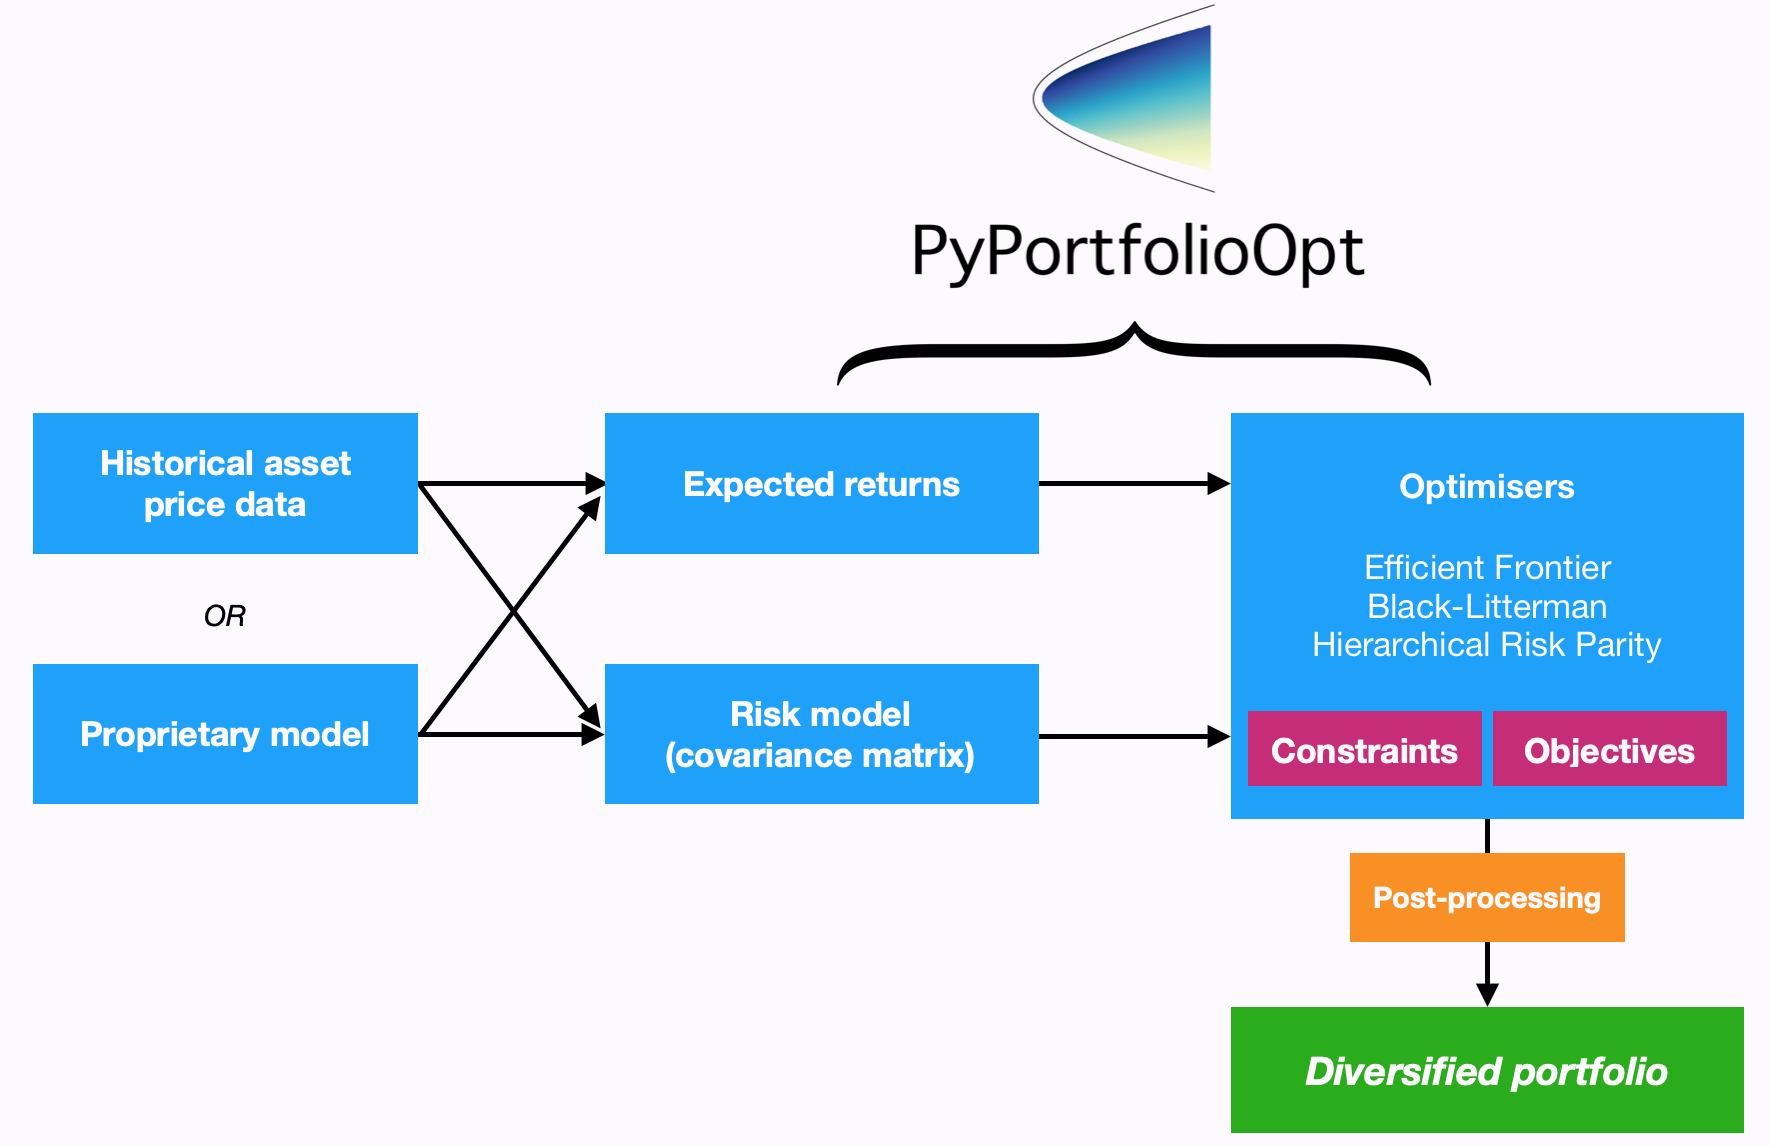

In [18]:
import pypfopt
pypfopt.__version__

'1.4.1'

#### Riesgo de los Activos y Grado de Aversión al Riesgo del Inversionista

De la paquetería de *PyPortafolioOpt* importamos el **Modelo de Black & Litterman** y los gráficos de dicho modelo para su aplicación posterior.

Con dicha paquetería obtenemos la **Matriz de Varianza-Covarianza (S)**. 


Asimismo, se obtiene el **Grado de Aversión al Riesgo (A)** con la paquetería de *pypfopt* y el modelo black & litterman. 

In [19]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.risk_matrix(close_prices_train, method='semicovariance')
S


,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
AAPL,0.046738,0.023710,0.044064,0.016658,0.031347,0.033877,0.040359,0.027723,0.042472,0.025189,0.034772,0.018832,0.020388,0.031689
AME,0.023710,0.036502,0.045858,0.018943,0.034649,0.030947,0.041480,0.024297,0.043263,0.022772,0.038617,0.020051,0.021635,0.026984
BAC,0.044064,0.045858,0.143364,0.033526,0.064675,0.059640,0.077984,0.045018,0.107853,0.041775,0.087265,0.034417,0.041533,0.058490
CNP,0.016658,0.018943,0.033526,0.028618,0.026059,0.023003,0.033074,0.017560,0.032867,0.016620,0.029443,0.014622,0.018838,0.022847
CNS,0.031347,0.034649,0.064675,0.026059,0.076980,0.043278,0.061269,0.033745,0.060773,0.029061,0.054588,0.026489,0.029088,0.035329
EXPE,0.033877,0.030947,0.059640,0.023003,0.043278,0.105212,0.053957,0.032532,0.056076,0.030636,0.049905,0.025969,0.026681,0.033065
FTEK,0.040359,0.041480,0.077984,0.033074,0.061269,0.053957,0.167962,0.039529,0.074353,0.036115,0.066050,0.031726,0.034644,0.049927
INTC,0.027723,0.024297,0.045018,0.017560,0.033745,0.032532,0.039529,0.041745,0.042810,0.026838,0.037818,0.020363,0.020418,0.024802
KEY,0.042472,0.043263,0.107853,0.032867,0.060773,0.056076,0.074353,0.042810,0.137951,0.038516,0.088023,0.033218,0.037298,0.049030
MSFT,0.025189,0.022772,0.041775,0.016620,0.029061,0.030636,0.036115,0.026838,0.038516,0.036045,0.035004,0.019070,0.019946,0.025036


In [20]:
A_r = black_litterman.market_implied_risk_aversion(market_prices, risk_free_rate=rf)
A = A_r           ## Aversión al riesgo implicita del mercado
A

array([1.63594315])

#### Gráfico Matriz Varianza-Covarianzas (S)

<AxesSubplot:>

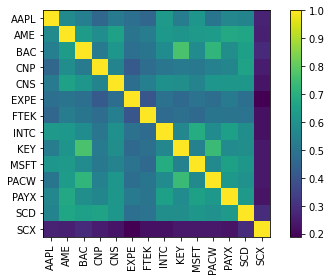

In [21]:
plotting.plot_covariance(S, plot_correlation=True)

#### Retornos Implicitos del Mercado

Obtenemos los retornos implicitos del mercado como market_prior *(considerado como $ \pi $ en la formula general del Modelo Black & Litterman)*

* Los retornos implicitos del Mercado se desarrollan mediante la consideración del **Grado de Aversión al Riesgo (A)**, los **Pesos implicitos del mercado (w)** que se obtienen de la ponderación de capitalización del mercado de las acciones a consdierar y la **Matriz de Varianza Covarianza (S)** mediante la siguiente formula: $ \Pi $ = ASw


* Dicha relación refleja en el modelo que el retorno esperado tiene una relación intima con el el grado de aversión al riesgo, riesgo de los activos y los pesos asignados a los mismos. Ante esto, se considera un equilibrio implícito de retornos excesivos del mercado denotados como un vector π, el cual optimiza la utilidad.


* Se grafican los retornos implicitos de mercado ($ \pi $)

In [22]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, A, S)
market_prior

AAPL    0.078055
AME     0.062993
BAC     0.110774
CNP     0.051077
CNS     0.077223
EXPE    0.079137
FTEK    0.090976
INTC    0.070510
KEY     0.100886
MSFT    0.071374
PACW    0.088621
PAYX    0.054584
SCD     0.057411
SCX     0.071619
dtype: float64

<AxesSubplot:>

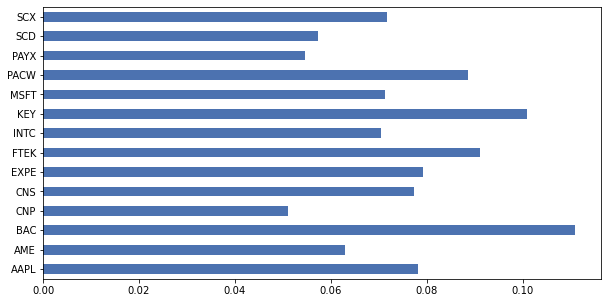

In [23]:
market_prior.plot.barh(figsize=(10,5))

### Modelo 1: Expectativas con Promedio trimestral de Earnings Per Share 2018 (Ganancias por acción) 

In [24]:
bl_1 = BlackLittermanModel(S, pi=market_prior, absolute_views=views_1, risk_aversion=1, risk_free_rate=rf)

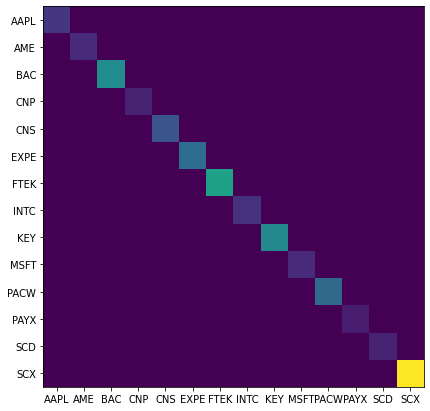

In [25]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl_1.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl_1.tickers)))
ax.set_yticks(np.arange(len(bl_1.tickers)))

ax.set_xticklabels(bl_1.tickers)
ax.set_yticklabels(bl_1.tickers)
plt.show()

In [26]:
np.diag(bl_1.omega)

array([0.00233688, 0.00182512, 0.00716818, 0.00143091, 0.003849  ,
       0.00526062, 0.00839809, 0.00208723, 0.00689756, 0.00180223,
       0.00510138, 0.00119388, 0.00144485, 0.01468048])

#### Calculando y comparando los retornos

**Retornos posteriores a considerar las expectativas y los niveles de confianza del inversionista**

In [27]:
ret_bl_1 = bl_1.bl_returns()
ret_bl_1

AAPL     3.771083
AME      2.338123
BAC      4.680461
CNP      0.925065
CNS      3.608798
EXPE    52.156985
FTEK     4.669884
INTC     2.263839
KEY      3.893206
MSFT     2.665845
PACW     3.855555
PAYX     2.669109
SCD      1.781461
SCX      1.138772
dtype: float64

In [28]:
rets_df_1 = pd.DataFrame([market_prior, ret_bl_1, pd.Series(views_1)], 
             index=["Retornos implícitos", "Retornos Posteriores", "Expectativa de Retorno"]).T
rets_df_1

,Retornos implícitos,Retornos Posteriores,Expectativa de Retorno
AAPL,0.078055,3.771083,0.060212
AME,0.062993,2.338123,-0.018972
BAC,0.110774,4.680461,0.435029
CNP,0.051077,0.925065,-1.453165
CNS,0.077223,3.608798,0.072660
EXPE,0.079137,52.156985,130.066068
FTEK,0.090976,4.669884,0.859948
INTC,0.070510,2.263839,-1.811880
KEY,0.100886,3.893206,0.334895
MSFT,0.071374,2.665845,-0.506247


<AxesSubplot:>

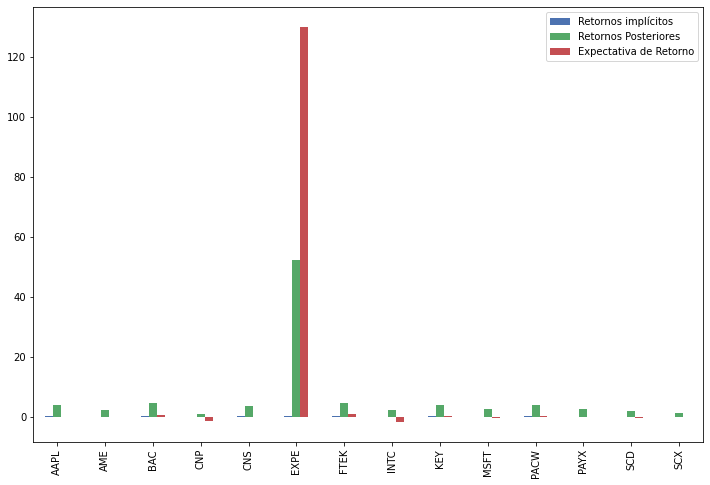

In [29]:
rets_df_1.plot.bar(figsize=(12,8))

Se aprecia en el gráfico que el retorno posterior suele estar entre los retornos implícitos del mercado y las expectativas del inversionista. Esto respalda el hecho de que el modelo Black & Litterman es esencialmente un promedio ponderado bayesiano de las expectativas del inversionista y, donde el peso está determinado por la confianza.

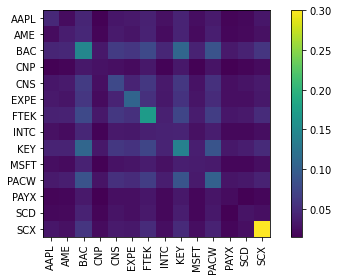

In [30]:
S_bl_1 = bl_1.bl_cov()
plotting.plot_covariance(S_bl_1);

#### Frontera Eficiente

In [31]:
from pypfopt import EfficientFrontier, objective_functions

In [32]:
ef_1= EfficientFrontier(ret_bl_1, S_bl_1)
ef_1.add_objective(objective_functions.L2_reg)
ef_1.max_sharpe()
weights_1 = ef_1.clean_weights()
weights_1

C:\Users\alanf\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:247: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.0317),
             ('AME', 0.00942),
             ('BAC', 0.02043),
             ('CNP', 0.0),
             ('CNS', 0.01889),
             ('EXPE', 0.82097),
             ('FTEK', 0.02509),
             ('INTC', 0.0067),
             ('KEY', 0.01031),
             ('MSFT', 0.01573),
             ('PACW', 0.0162),
             ('PAYX', 0.02052),
             ('SCD', 0.00404),
             ('SCX', 0.0)])

#### Asignación de pesos (w) del portafolio 1

In [33]:
shares_1 = pd.DataFrame.from_dict(list(weights_1.items()))
shares_1 = shares_1.rename(columns={0:'symbol', 1:'w'})

w1_v = shares_1['w'].values
w1_v = w1_v.tolist()

ticker_w1 = shares_1['symbol'].values
ticker_w1 = ticker_w1.tolist()
ticker_w1

shares_1

,symbol,w
0,AAPL,0.03170
1,AME,0.00942
2,BAC,0.02043
3,CNP,0.00000
4,CNS,0.01889
5,EXPE,0.82097
6,FTEK,0.02509
7,INTC,0.00670
8,KEY,0.01031
9,MSFT,0.01573


<AxesSubplot:ylabel='None'>

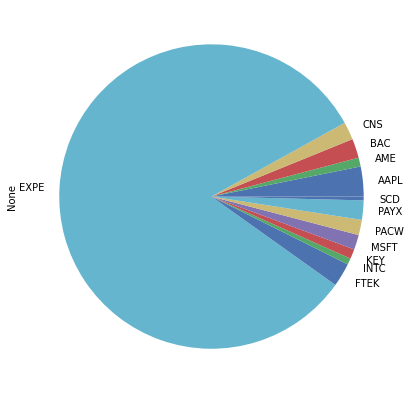

In [34]:
pd.Series(weights_1).plot.pie(figsize=(20,7))

#### Portafolio 1: Número de acciones a comprar con 100,000 USD

In [35]:
da_1 = pypfopt.discrete_allocation.DiscreteAllocation(weights_1, close_prices_train.iloc[-1], total_portfolio_value=100000)
alloc_1, leftover = da_1.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc_1

Leftover: $0.16


{'AAPL': 80,
 'AME': 14,
 'BAC': 83,
 'CNS': 55,
 'EXPE': 729,
 'FTEK': 2106,
 'INTC': 14,
 'KEY': 70,
 'MSFT': 15,
 'PACW': 49,
 'PAYX': 32,
 'SCD': 38}

#### Comportamiento Previsto del Portafolio 1

In [36]:
shares_1 = pd.DataFrame.from_dict(list(alloc_1.items()))
shares_1 = shares_1.rename(columns={0:'symbol', 1:'shares'})

ticker_alloc_1 = shares_1['symbol'].values
ticker_alloc_1 = ticker_alloc_1.tolist()

shares_T = shares_1.set_index("symbol")
shares_T = shares_T.T
shares_T

symbol,AAPL,AME,BAC,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD
shares,80,14,83,55,729,2106,14,70,15,49,32,38


In [37]:
future_portafolio_alloc = close_prices_pred[ticker_w1]
future_portafolio_alloc

,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
date,,,,,,,,,,,,,,
2019-01-02,39.480000,67.489998,24.959999,28.000000,34.419998,111.980003,1.25,47.080002,15.020000,101.120003,33.490002,65.070000,11.02,5.56
2019-01-03,35.547501,65.570000,24.559999,28.160000,34.439999,108.519997,1.19,44.490002,15.070000,97.400002,33.169998,63.970001,10.82,5.52
2019-01-04,37.064999,68.050003,25.580000,28.680000,35.540001,113.089996,1.27,47.220001,15.580000,101.930000,34.330002,66.199997,11.20,5.70
2019-01-07,36.982498,67.940002,25.559999,28.790001,35.740002,114.559998,1.20,47.439999,15.740000,102.059998,34.650002,65.849998,11.48,5.65
2019-01-08,37.687500,68.940002,25.510000,29.340000,36.099998,116.970001,1.27,47.740002,15.730000,102.800003,35.259998,66.349998,11.70,5.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.067497,99.709999,35.220001,26.760000,62.650002,108.769997,0.87,59.410000,20.350000,157.380005,38.720001,84.650002,15.31,5.72
2019-12-26,72.477501,100.070000,35.520000,26.910000,62.830002,109.070000,0.87,59.820000,20.370001,158.669998,38.660000,84.709999,15.23,5.70
2019-12-27,72.449997,99.949997,35.349998,26.910000,62.660000,108.320000,0.86,60.080002,20.280001,158.960007,38.299999,85.120003,14.99,5.70


Text(0, 0.5, 'price in $')

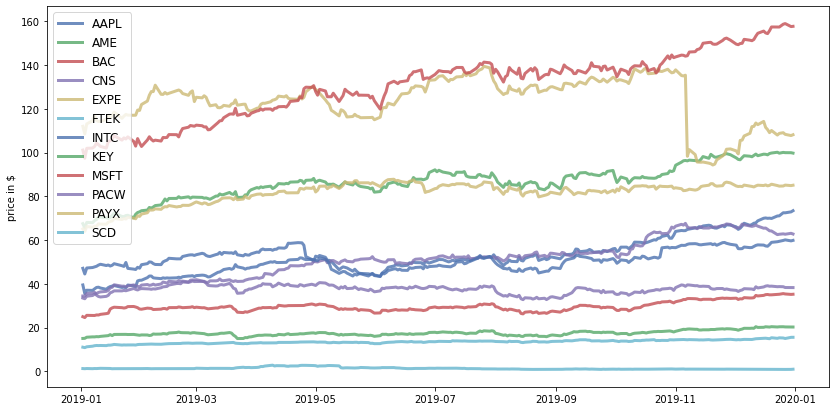

In [38]:
#Seleccionamos los precios de 2019 de las acciones del portafolio formado
future_prices_portfolio = close_prices_pred[ticker_alloc_1]
future_prices_portfolio

##Graficamos los precios
plt.figure(figsize=(14, 7))
for c in future_prices_portfolio.columns.values:
    plt.plot(future_prices_portfolio.index, future_prices_portfolio[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

[*********************100%***********************]  1 of 1 completed


C:\Users\alanf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


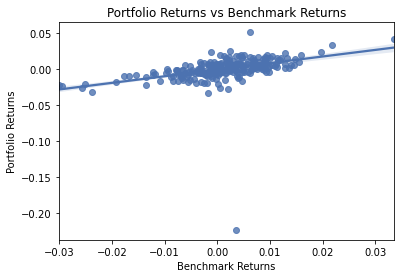

In [39]:
ret_stocks = future_portafolio_alloc.pct_change()[1:]
port_ret = (ret_stocks * w1_v).sum(axis = 1)
port_ret = pd.DataFrame(port_ret)
port_ret.index = pd.to_datetime(port_ret.index, format = '%Y-%m-%d')
port_ret = port_ret.rename(columns={0: 'port_returns'})
port_ret

benchmark_ret = yf.download("SPY", start="2019-01-01", end="2020-01-02")["Adj Close"].pct_change()[1:]
benchmark_ret = pd.DataFrame(benchmark_ret)
benchmark_ret.index = pd.to_datetime(benchmark_ret.index, format = '%Y-%m-%d')
benchmark_ret = benchmark_ret.rename(columns={'Adj Close': 'SP500_returns'})
benchmark_ret

data = pd.concat([benchmark_ret, port_ret], axis=1)

sns.regplot(benchmark_ret.values, port_ret.values)
plt.xlabel("Benchmark Returns")
plt.ylabel("Portfolio Returns")
plt.title("Portfolio Returns vs Benchmark Returns")
plt.show()

In [40]:
covariance_matrix = data[["SP500_returns","port_returns"]].cov()
covariance_coefficient = covariance_matrix.iloc[0,1]
benchmark_variance = data["SP500_returns"].var()
portfolio_beta = covariance_coefficient / benchmark_variance
portfolio_beta

0.916900555654739

In [41]:
portafolio_value = future_prices_portfolio.multiply(np.array(shares_T), axis='columns')
portafolio_value['value_port'] = portafolio_value.sum(axis=1)
portafolio_value = portafolio_value.drop(columns=ticker_alloc_1)
portafolio_value['Portfolio Daily Returns'] = portafolio_value["value_port"].pct_change()
portafolio_value['Log Portfolio Daily Returns'] = np.log(portafolio_value.value_port) - np.log(portafolio_value.value_port.shift(1))
portafolio_value['Portfolio Cumulative Returns'] = (1 + portafolio_value['Portfolio Daily Returns']).cumprod() - 1
portafolio_value = portafolio_value.fillna(0)
portafolio_value[["Portfolio Daily Returns", "Log Portfolio Daily Returns", "Portfolio Cumulative Returns"]] = portafolio_value[["Portfolio Daily Returns", "Log Portfolio Daily Returns", "Portfolio Cumulative Returns"]].astype(np.float64)
portafolio_value

,value_port,Portfolio Daily Returns,Log Portfolio Daily Returns,Portfolio Cumulative Returns
date,,,,
2019-01-02,99703.292137,0.000000,0.000000,0.000000
2019-01-03,96533.967747,-0.031788,-0.032304,-0.031788
2019-01-04,100619.767117,0.042325,0.041454,0.009192
2019-01-07,101576.528427,0.009509,0.009464,0.018788
2019-01-08,103635.740558,0.020273,0.020070,0.039442
...,...,...,...,...
2019-12-24,104380.697940,0.006059,0.006041,0.046913
2019-12-26,104774.470198,0.003772,0.003765,0.050863
2019-12-27,104167.369802,-0.005794,-0.005811,0.044774


Text(0, 0.5, 'Returns %')

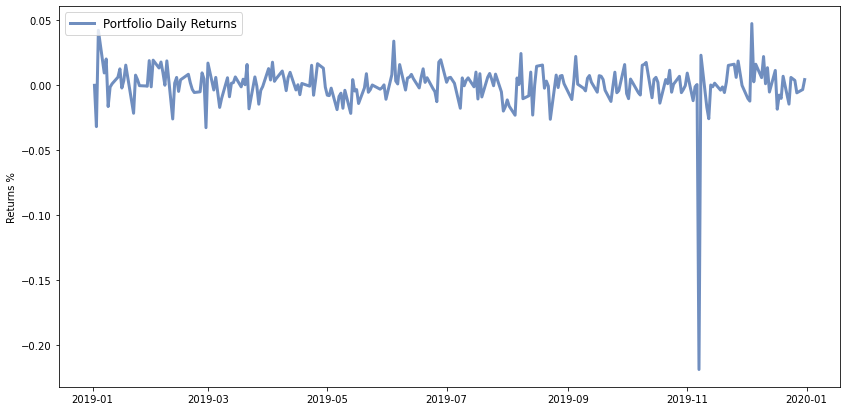

In [42]:
##Graficamos los retornos
plt.figure(figsize=(14, 7))
for c in portafolio_value.columns.values[1:2]:
    plt.plot(portafolio_value.index, portafolio_value[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Returns %')

Start date,2019-01-02
End date,2019-12-31
Total months,12
,Backtest
Annual return,4.6%
Cumulative returns,4.6%
Annual volatility,28.3%
Sharpe ratio,0.31
Calmar ratio,0.18
Stability,0.00
Max drawdown,-25.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.11,2019-11-01,2019-11-20,NaT,NaN
1,12.23,2019-04-29,2019-05-31,2019-07-02,47
2,8.95,2019-07-26,2019-08-15,2019-10-23,64
3,5.79,2019-02-08,2019-03-29,2019-04-11,45
4,3.18,2019-01-02,2019-01-03,2019-01-04,3


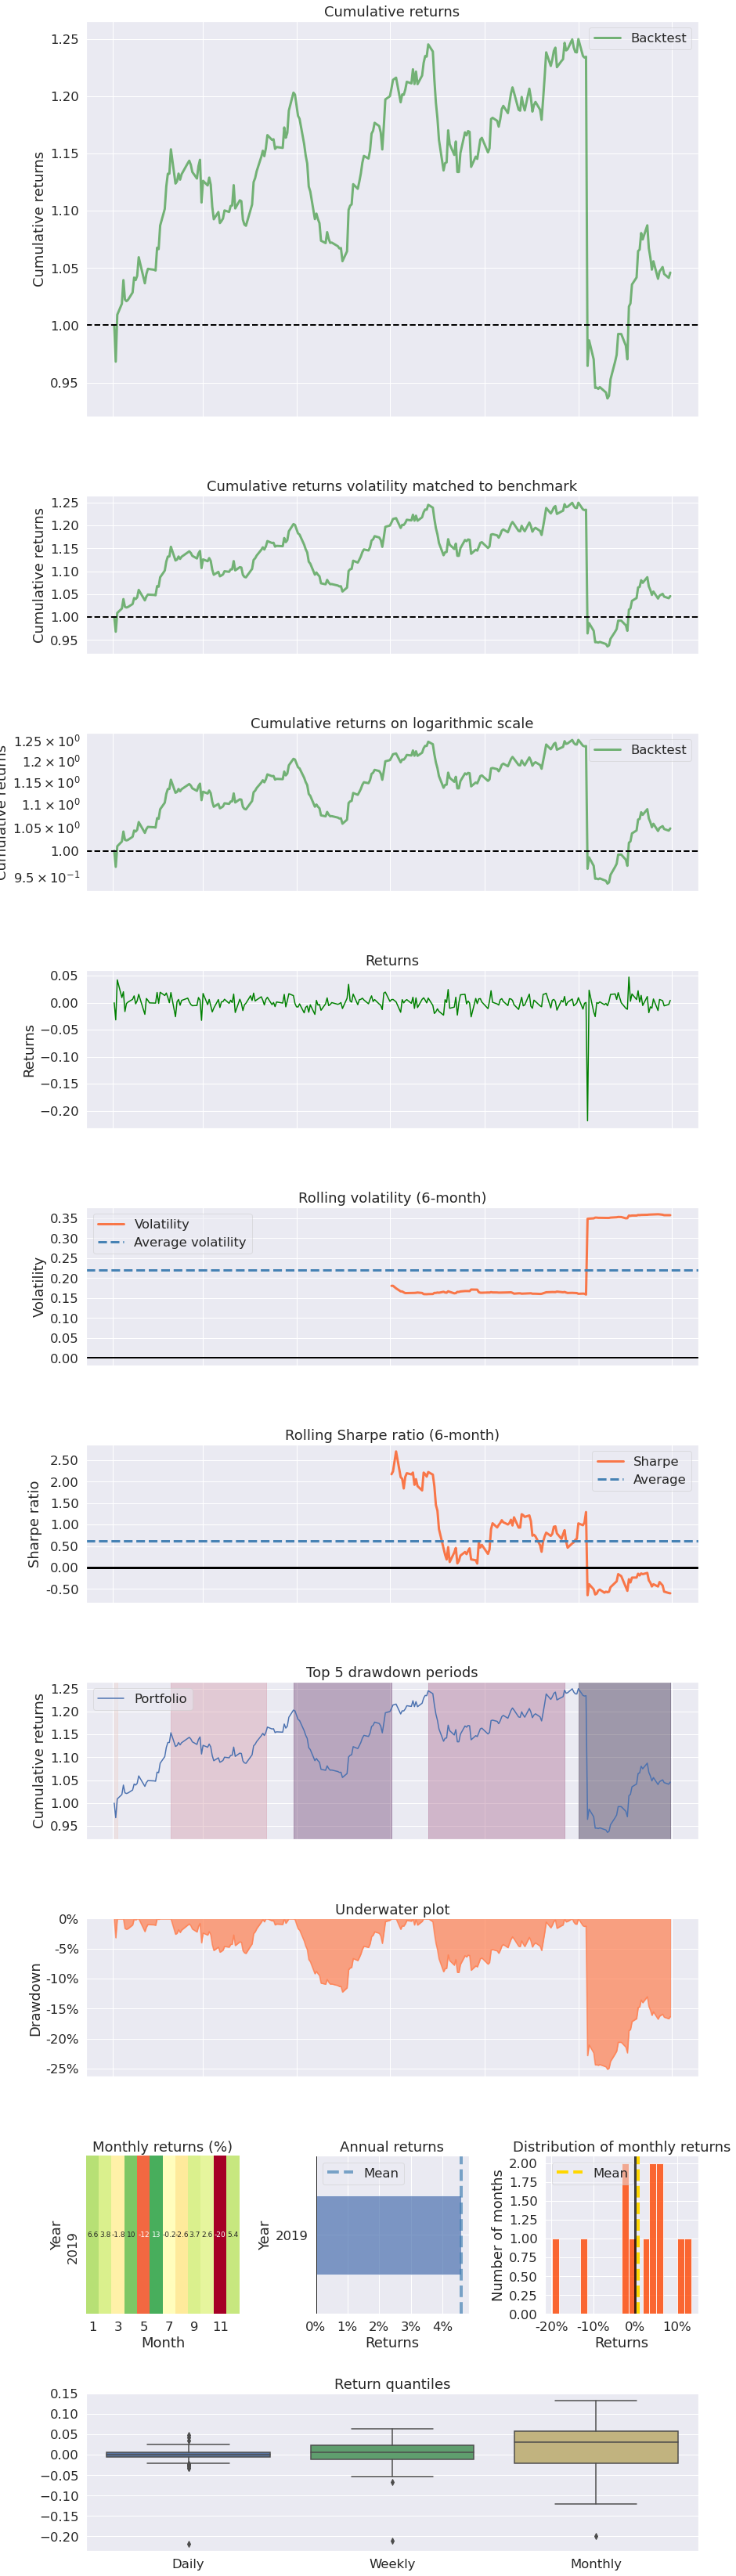

In [43]:
pf.create_returns_tear_sheet(portafolio_value['Portfolio Daily Returns'])

In [44]:
metrics = [
    'Rendimiento Anualizado',
    'Rendimiento Acumulado',
    'Rendimiento Ajustado por Riesgo de Modigliani',
    'Volatilidad Anual',
    'Sharpe Ratio',
    'Treynor Ratio',
    'Jensen-Alpha Ratio']
columns = ['Portfolio 1']
# Establecer un dataframe para los indicadores del portafolio
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)


#Rendimiento Acumulado
portfolio_evaluation_df.loc['Rendimiento Acumulado'] = portafolio_value['Portfolio Cumulative Returns'][-1]

#Rendimiento Anualizado
portfolio_evaluation_df.loc['Rendimiento Anualizado'] = (
    portafolio_value['Portfolio Daily Returns'].mean() * 252
)
#Volatilidad Anual
portfolio_evaluation_df.loc['Volatilidad Anual'] = (
    portafolio_value['Portfolio Daily Returns'].std() * np.sqrt(252)
)
#Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    portafolio_value['Portfolio Daily Returns'].mean() * 252) / (
    portafolio_value['Portfolio Daily Returns'].std() * np.sqrt(252)
)
#Treynor Ratio
portfolio_evaluation_df.loc['Treynor Ratio'] = ((portafolio_value['Portfolio Daily Returns'].mean() * 252) / portfolio_beta)

#Rendimiento Ajustado por Riesgo de Modigliani
portfolio_evaluation_df.loc['Rendimiento Ajustado por Riesgo de Modigliani'] = ((portafolio_value['Portfolio Daily Returns'].mean() * 252) * (benchmark_ret['SP500_returns'].std()/portafolio_value['Portfolio Daily Returns'].std()) )

#Jensen-Alpha Ratio
portfolio_evaluation_df.loc['Jensen-Alpha Ratio'] = ((portafolio_value['Portfolio Daily Returns'].mean() * 252) - (benchmark_ret['SP500_returns'].mean() * 252) * portfolio_beta)


portafolio1_mediciones = portfolio_evaluation_df.to_csv("portafolio1_mediciones.csv")
portfolio_evaluation_df

,Portfolio 1
Rendimiento Anualizado,0.0891013
Rendimiento Acumulado,0.045974
Rendimiento Ajustado por Riesgo de Modigliani,0.0394076
Volatilidad Anual,0.283439
Sharpe Ratio,0.314358
Treynor Ratio,0.0971767
Jensen-Alpha Ratio,-0.167414


### Modelo 2: Expectativas considerando la mediana de crecimiento de las ganancias por acción un año previo a la decisión de construir el portafolio.

In [45]:
bl_2 = BlackLittermanModel(S, pi=market_prior, absolute_views=views_2, risk_aversion=1, risk_free_rate=rf)

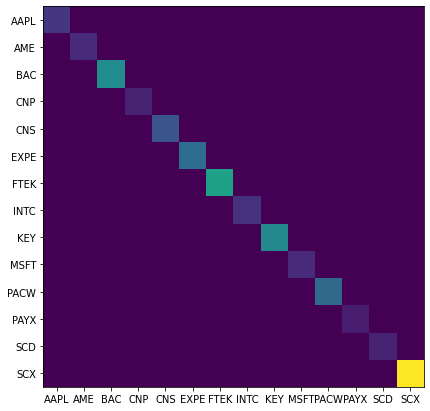

In [46]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl_1.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl_2.tickers)))
ax.set_yticks(np.arange(len(bl_2.tickers)))

ax.set_xticklabels(bl_2.tickers)
ax.set_yticklabels(bl_2.tickers)
plt.show()

In [47]:
np.diag(bl_2.omega)

array([0.00233688, 0.00182512, 0.00716818, 0.00143091, 0.003849  ,
       0.00526062, 0.00839809, 0.00208723, 0.00689756, 0.00180223,
       0.00510138, 0.00119388, 0.00144485, 0.01468048])

#### Calculando y comparando los retornos

**Retornos posteriores a considerar las expectativas y los niveles de confianza del inversionista**

In [48]:
ret_bl_2 = bl_2.bl_returns()
ret_bl_2

AAPL   -0.057138
AME    -0.112228
BAC    -0.147164
CNP    -0.480558
CNS    -0.149034
EXPE   -0.473619
FTEK   -0.365731
INTC   -0.078874
KEY    -0.125219
MSFT   -0.089258
PACW   -0.143127
PAYX   -0.079954
SCD    -0.274680
SCX    -0.309790
dtype: float64

In [49]:
rets_df_2 = pd.DataFrame([market_prior, ret_bl_2, pd.Series(views_2)], 
             index=["Retornos implícitos", "Retornos Posteriores", "Expectativa de Retorno"]).T
rets_df_2

,Retornos implícitos,Retornos Posteriores,Expectativa de Retorno
AAPL,0.078055,-0.057138,0.051972
AME,0.062993,-0.112228,0.025693
BAC,0.110774,-0.147164,0.053288
CNP,0.051077,-0.480558,-1.158437
CNS,0.077223,-0.149034,0.057152
EXPE,0.079137,-0.473619,-0.987355
FTEK,0.090976,-0.365731,-0.471292
INTC,0.070510,-0.078874,-0.023133
KEY,0.100886,-0.125219,0.089289
MSFT,0.071374,-0.089258,-0.026087


<AxesSubplot:>

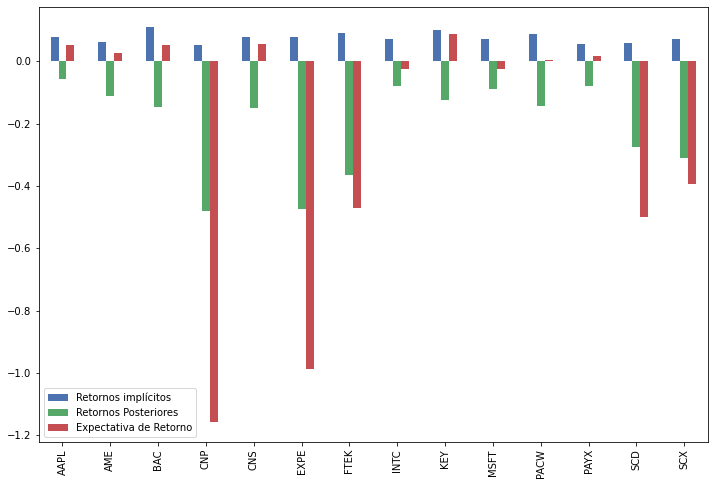

In [50]:
rets_df_2.plot.bar(figsize=(12,8))

<AxesSubplot:>

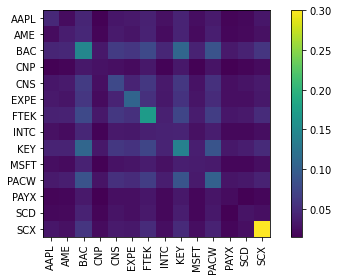

In [51]:
S_bl_2 = bl_2.bl_cov()
plotting.plot_covariance(S_bl_2)

#### Asignación de pesos (w) del portafolio 2

In [52]:
ef_2= EfficientFrontier(ret_bl_2, S_bl_2)
ef_2.add_objective(objective_functions.L2_reg)
ef_2.min_volatility()
weights_2 = ef_2.clean_weights()
weights_2

OrderedDict([('AAPL', 0.0797),
             ('AME', 0.08042),
             ('BAC', 0.05105),
             ('CNP', 0.08694),
             ('CNS', 0.06857),
             ('EXPE', 0.06852),
             ('FTEK', 0.05598),
             ('INTC', 0.07986),
             ('KEY', 0.0538),
             ('MSFT', 0.08206),
             ('PACW', 0.06107),
             ('PAYX', 0.08679),
             ('SCD', 0.08414),
             ('SCX', 0.06111)])

In [53]:
shares_2 = pd.DataFrame.from_dict(list(weights_2.items()))
shares_2 = shares_2.rename(columns={0:'symbol', 1:'w'})

w2_v = shares_2['w'].values
w2_v = w2_v.tolist()

ticker_w2 = shares_2['symbol'].values
ticker_w2 = ticker_w2.tolist()
ticker_w2

shares_2

,symbol,w
0,AAPL,0.07970
1,AME,0.08042
2,BAC,0.05105
3,CNP,0.08694
4,CNS,0.06857
5,EXPE,0.06852
6,FTEK,0.05598
7,INTC,0.07986
8,KEY,0.05380
9,MSFT,0.08206


<AxesSubplot:ylabel='None'>

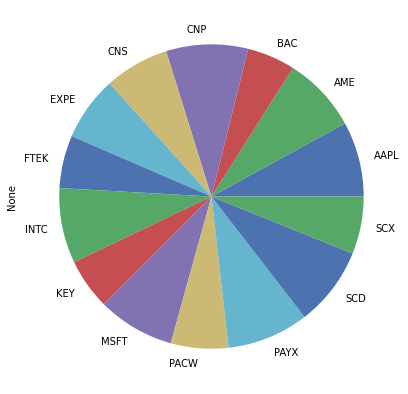

In [54]:
pd.Series(weights_2).plot.pie(figsize=(20,7))

#### Portafolio 2: Número de acciones a comprar con 100,000 USD

In [55]:
da_2 = pypfopt.discrete_allocation.DiscreteAllocation(weights_2, close_prices_train.iloc[-1], total_portfolio_value=100000)
alloc_2, leftover2 = da_2.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc_2

Leftover: $0.16


{'AAPL': 202,
 'AME': 119,
 'BAC': 207,
 'CNP': 308,
 'CNS': 200,
 'EXPE': 61,
 'FTEK': 4704,
 'INTC': 170,
 'KEY': 364,
 'MSFT': 81,
 'PACW': 183,
 'PAYX': 133,
 'SCD': 787,
 'SCX': 1167}

In [56]:
shares_2 = pd.DataFrame.from_dict(list(alloc_2.items()))
shares_2 = shares_2.rename(columns={0:'symbol', 1:'shares'})

ticker_alloc_2 = shares_2['symbol'].values
ticker_alloc_2 = ticker_alloc_2.tolist()

shares_T2 = shares_2.set_index("symbol")
shares_T2 = shares_T2.T
shares_T2

symbol,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
shares,202,119,207,308,200,61,4704,170,364,81,183,133,787,1167


In [57]:
ef_2.portfolio_performance(verbose=True)

Expected annual return: -20.4%
Annual volatility: 19.1%
Sharpe Ratio: -1.18


(-0.20409911325784927, 0.19055487002836224, -1.1760345627718372)

#### Comportamiento Previsto Portafolio 2

In [58]:
future_portafolio_alloc2 = close_prices_pred[ticker_w2]
future_portafolio_alloc2

,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
date,,,,,,,,,,,,,,
2019-01-02,39.480000,67.489998,24.959999,28.000000,34.419998,111.980003,1.25,47.080002,15.020000,101.120003,33.490002,65.070000,11.02,5.56
2019-01-03,35.547501,65.570000,24.559999,28.160000,34.439999,108.519997,1.19,44.490002,15.070000,97.400002,33.169998,63.970001,10.82,5.52
2019-01-04,37.064999,68.050003,25.580000,28.680000,35.540001,113.089996,1.27,47.220001,15.580000,101.930000,34.330002,66.199997,11.20,5.70
2019-01-07,36.982498,67.940002,25.559999,28.790001,35.740002,114.559998,1.20,47.439999,15.740000,102.059998,34.650002,65.849998,11.48,5.65
2019-01-08,37.687500,68.940002,25.510000,29.340000,36.099998,116.970001,1.27,47.740002,15.730000,102.800003,35.259998,66.349998,11.70,5.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.067497,99.709999,35.220001,26.760000,62.650002,108.769997,0.87,59.410000,20.350000,157.380005,38.720001,84.650002,15.31,5.72
2019-12-26,72.477501,100.070000,35.520000,26.910000,62.830002,109.070000,0.87,59.820000,20.370001,158.669998,38.660000,84.709999,15.23,5.70
2019-12-27,72.449997,99.949997,35.349998,26.910000,62.660000,108.320000,0.86,60.080002,20.280001,158.960007,38.299999,85.120003,14.99,5.70


Text(0, 0.5, 'price in $')

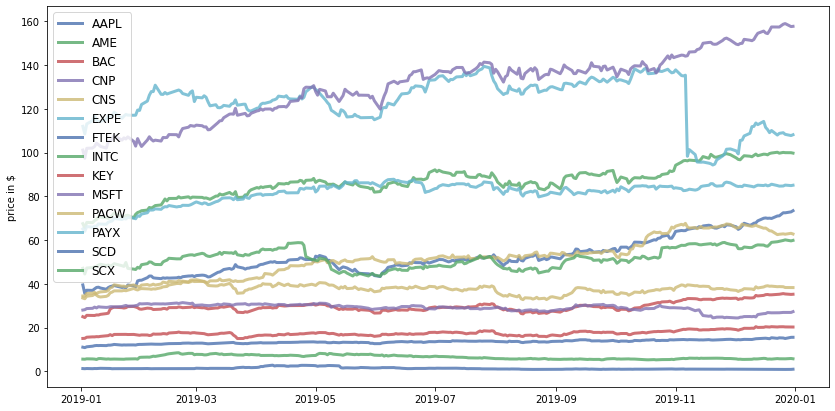

In [59]:
#Seleccionamos los precios de 2019 de las acciones del portafolio formado
future_prices_portfolio2 = close_prices_pred[ticker_w2]
future_prices_portfolio2

##Graficamos los precios
plt.figure(figsize=(14, 7))
for c in future_prices_portfolio2.columns.values:
    plt.plot(future_prices_portfolio2.index, future_prices_portfolio2[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

C:\Users\alanf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


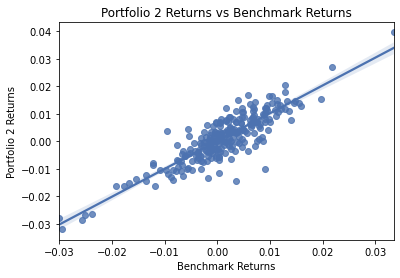

In [60]:
ret_stocks2 = future_portafolio_alloc2.pct_change()[1:]
port_ret2 = (ret_stocks2 * w2_v).sum(axis = 1)
port_ret2 = pd.DataFrame(port_ret2)
port_ret2.index = pd.to_datetime(port_ret2.index, format = '%Y-%m-%d')
port_ret2 = port_ret2.rename(columns={0: 'port2_returns'})
port_ret2

data2 = pd.concat([benchmark_ret, port_ret2], axis=1)

sns.regplot(benchmark_ret.values, port_ret2.values)
plt.xlabel("Benchmark Returns")
plt.ylabel("Portfolio 2 Returns")
plt.title("Portfolio 2 Returns vs Benchmark Returns")
plt.show()

In [61]:
covariance_matrix2 = data2[["SP500_returns","port2_returns"]].cov()
covariance_coefficient2 = covariance_matrix2.iloc[0,1]
benchmark_variance2 = data2["SP500_returns"].var()
portfolio_beta2 = covariance_coefficient2 / benchmark_variance2
portfolio_beta2

1.0114815266461235

In [62]:
portafolio_value2 = future_prices_portfolio2.multiply(np.array(shares_T2), axis='columns')
portafolio_value2['value_port2'] = portafolio_value2.sum(axis=1)
portafolio_value2 = portafolio_value2.drop(columns=ticker_alloc_2)
portafolio_value2['Portfolio 2 Daily Returns'] = portafolio_value2["value_port2"].pct_change()
portafolio_value2['Log Portfolio 2 Daily Returns'] = np.log(portafolio_value2.value_port2) - np.log(portafolio_value2.value_port2.shift(1))
portafolio_value2['Portfolio 2 Cumulative Returns'] = (1 + portafolio_value2['Portfolio 2 Daily Returns']).cumprod() - 1
portafolio_value2 = portafolio_value2.fillna(0)
portafolio_value2[["Portfolio 2 Daily Returns", "Log Portfolio 2 Daily Returns", "Portfolio 2 Cumulative Returns"]] = portafolio_value2[["Portfolio 2 Daily Returns", "Log Portfolio 2 Daily Returns", "Portfolio 2 Cumulative Returns"]].astype(np.float64)
portafolio_value2

,value_port2,Portfolio 2 Daily Returns,Log Portfolio 2 Daily Returns,Portfolio 2 Cumulative Returns
date,,,,
2019-01-02,100997.610287,0.000000,0.000000,0.000000
2019-01-03,98319.584881,-0.026516,-0.026874,-0.026516
2019-01-04,102202.290248,0.039491,0.038731,0.011928
2019-01-07,102282.854981,0.000788,0.000788,0.012725
2019-01-08,103628.484850,0.013156,0.013070,0.026049
...,...,...,...,...
2019-12-24,132334.495553,0.002121,0.002119,0.310274
2019-12-26,132916.925671,0.004401,0.004392,0.316040
2019-12-27,132569.810110,-0.002612,-0.002615,0.312603


Text(0, 0.5, 'Returns %')

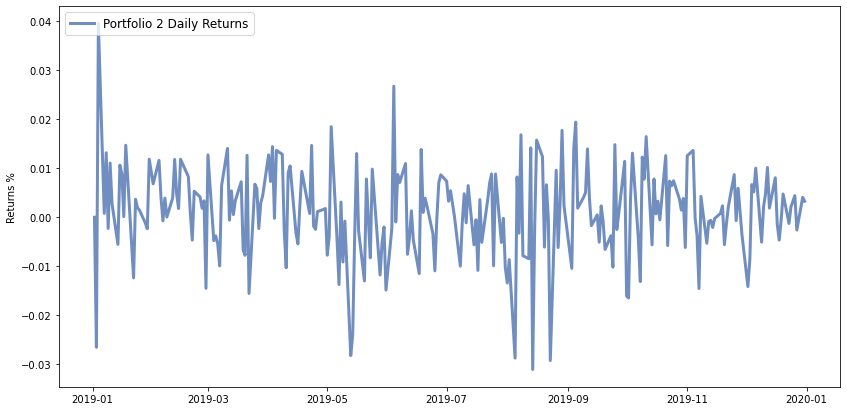

In [63]:
##Graficamos los retornos
plt.figure(figsize=(14, 7))
for c in portafolio_value2.columns.values[1:2]:
    plt.plot(portafolio_value2.index, portafolio_value2[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Returns %')

Start date,2019-01-02
End date,2019-12-31
Total months,12
,Backtest
Annual return,32.2%
Cumulative returns,32.2%
Annual volatility,14.8%
Sharpe ratio,1.96
Calmar ratio,2.57
Stability,0.50
Max drawdown,-12.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.55,2019-05-03,2019-08-23,2019-11-04,132
1,3.70,2019-11-04,2019-12-03,2019-12-16,31
2,2.65,2019-01-02,2019-01-03,2019-01-04,3
3,2.56,2019-02-27,2019-03-07,2019-03-15,13
4,1.74,2019-03-18,2019-03-22,2019-03-29,10


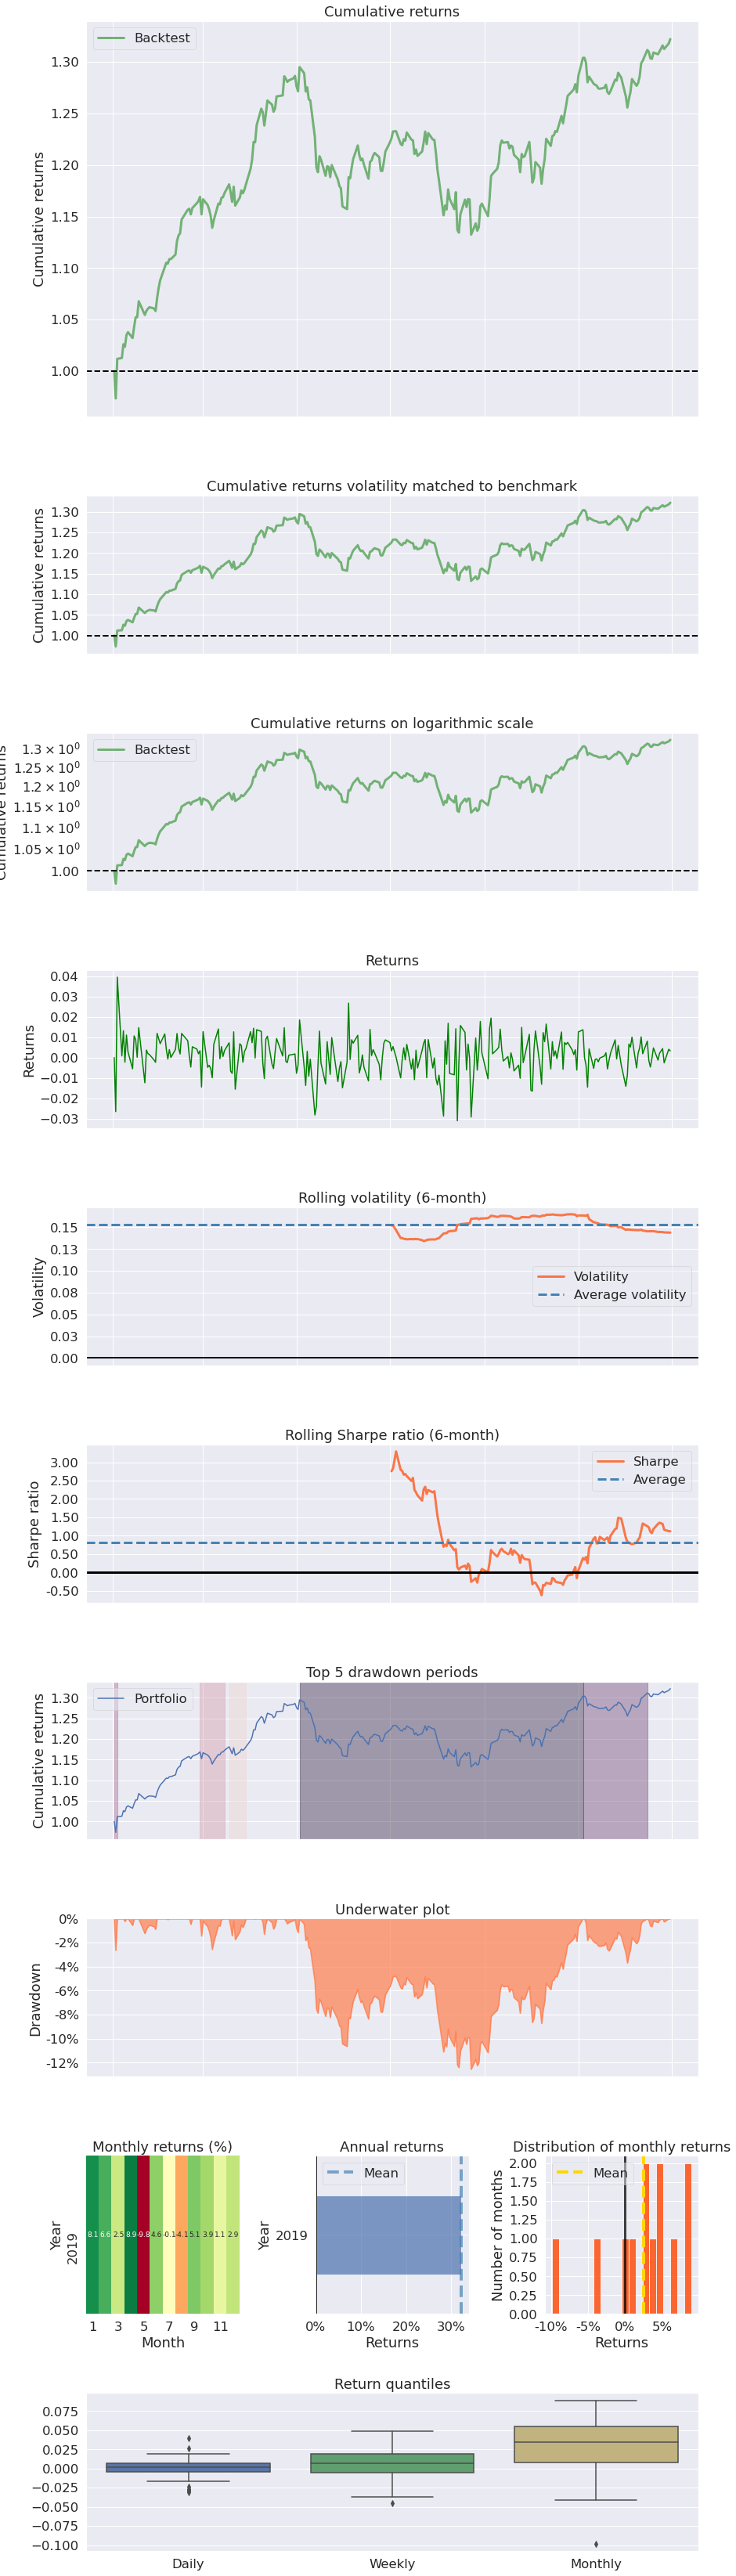

In [64]:
pf.create_returns_tear_sheet(portafolio_value2['Portfolio 2 Daily Returns'])

In [65]:
#metrics = [
#    'Rendimiento Anualizado',
#    'Rendimiento Acumulado',
#    'Rendimiento Ajustado por Riesgo de Modigliani',
#    'Volatilidad Anual',
#    'Sharpe Ratio',
#    'Treynor Ratio',
#    'Jensen-Alpha Ratio']
columns = ['Portfolio 2']
# Establecer un dataframe para los indicadores del portafolio
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)


#Rendimiento Acumulado
portfolio_evaluation_df.loc['Rendimiento Acumulado'] = portafolio_value2['Portfolio 2 Cumulative Returns'][-1]

#Rendimiento Anualizado
portfolio_evaluation_df.loc['Rendimiento Anualizado'] = (
    portafolio_value2['Portfolio 2 Daily Returns'].mean() * 252
)
#Volatilidad Anual
portfolio_evaluation_df.loc['Volatilidad Anual'] = (
    portafolio_value2['Portfolio 2 Daily Returns'].std() * np.sqrt(252)
)
#Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    portafolio_value2['Portfolio 2 Daily Returns'].mean() * 252) / (
    portafolio_value2['Portfolio 2 Daily Returns'].std() * np.sqrt(252)
)
#Treynor Ratio
portfolio_evaluation_df.loc['Treynor Ratio'] = (((
    portafolio_value2['Portfolio 2 Daily Returns'].mean() * 252)- rf) / portfolio_beta2)
#Rendimiento Ajustado por Riesgo de Modigliani
portfolio_evaluation_df.loc['Rendimiento Ajustado por Riesgo de Modigliani'] = (
    rf + ((portafolio_value2['Portfolio 2 Daily Returns'].mean() * 252) - rf) * (benchmark_ret['SP500_returns'].std()/portafolio_value2['Portfolio 2 Daily Returns'].std()) 
) 
#Jensen-Alpha Ratio
portfolio_evaluation_df.loc['Jensen-Alpha Ratio'] = ((
    (portafolio_value2['Portfolio 2 Daily Returns'].mean() * 252)- rf) - (
    (benchmark_ret['SP500_returns'].mean() * 252)- rf) * portfolio_beta2
)

portfolio_evaluation_df

,Portfolio 2
Rendimiento Anualizado,0.290397
Rendimiento Acumulado,0.322235
Rendimiento Ajustado por Riesgo de Modigliani,0.249638
Volatilidad Anual,0.147987
Sharpe Ratio,1.96231
Treynor Ratio,0.263536
Jensen-Alpha Ratio,0.00769476


### Modelo 3: Expectativas con Bolita de Cristal (Portafolio de Oro)

In [66]:
bl_3 = BlackLittermanModel(S, pi=market_prior, absolute_views=views_3, risk_aversion=1, risk_free_rate=rf)

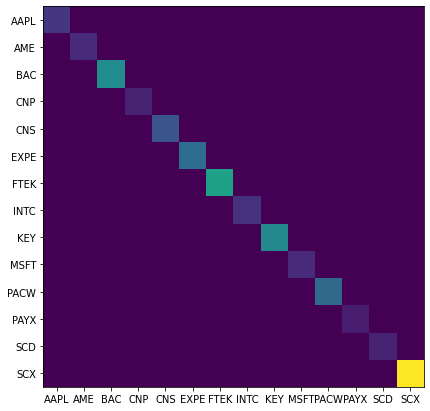

In [67]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl_3.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl_3.tickers)))
ax.set_yticks(np.arange(len(bl_3.tickers)))
bl_3 = BlackLittermanModel(S, pi=market_prior, absolute_views=views_3, risk_aversion=1, risk_free_rate=rf)
ax.set_xticklabels(bl_3.tickers)
ax.set_yticklabels(bl_3.tickers)
plt.show()

In [68]:
np.diag(bl_3.omega)

array([0.00233688, 0.00182512, 0.00716818, 0.00143091, 0.003849  ,
       0.00526062, 0.00839809, 0.00208723, 0.00689756, 0.00180223,
       0.00510138, 0.00119388, 0.00144485, 0.01468048])

In [69]:
ret_bl_3 = bl_3.bl_returns()
ret_bl_3

AAPL    0.492030
AME     0.342514
BAC     0.487098
CNP     0.139889
CNS     0.491702
EXPE    0.236245
FTEK    0.220497
INTC    0.335059
KEY     0.427815
MSFT    0.378183
PACW    0.335397
PAYX    0.259042
SCD     0.301087
SCX     0.230600
dtype: float64

In [70]:
rets_df_3 = pd.DataFrame([market_prior, ret_bl_3, pd.Series(views_3)], 
             index=["Retornos implícitos", "Retornos Posteriores", "Expectativa de Retorno"]).T
rets_df_3

,Retornos implícitos,Retornos Posteriores,Expectativa de Retorno
AAPL,0.078055,0.492030,0.861608
AME,0.062993,0.342514,0.473264
BAC,0.110774,0.487098,0.429383
CNP,0.051077,0.139889,-0.034006
CNS,0.077223,0.491702,0.828671
EXPE,0.079137,0.236245,-0.040036
FTEK,0.090976,0.220497,-0.201681
INTC,0.070510,0.335059,0.275304
KEY,0.100886,0.427815,0.369418
MSFT,0.071374,0.378183,0.552624


<AxesSubplot:>

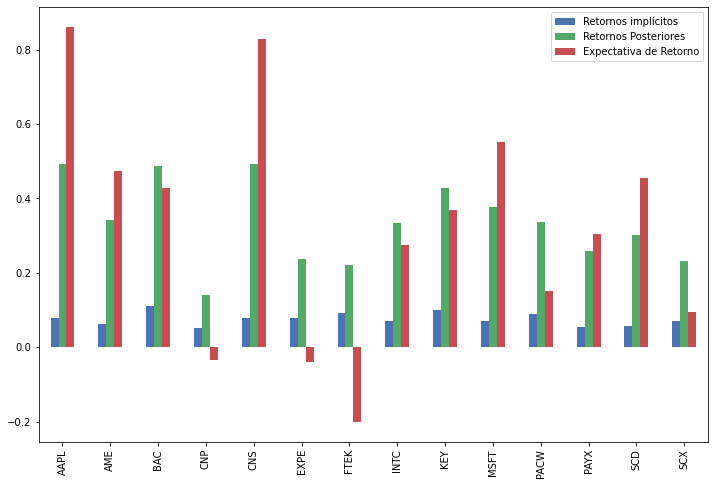

In [71]:
rets_df_3.plot.bar(figsize=(12,8))

<AxesSubplot:>

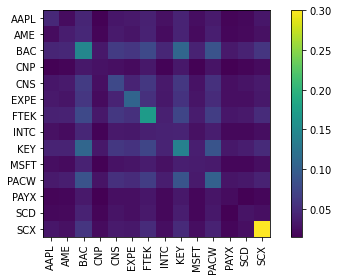

In [72]:
S_bl_3 = bl_3.bl_cov()
plotting.plot_covariance(S_bl_3)

#### Asignación de pesos (w) del portafolio 3

In [73]:
ef_3 = EfficientFrontier(ret_bl_3, S_bl_3)
ef_3.add_objective(objective_functions.L2_reg)
ef_3.max_sharpe()
weights_3 = ef_3.clean_weights()
weights_3

C:\Users\alanf\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:247: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.13484),
             ('AME', 0.08345),
             ('BAC', 0.10049),
             ('CNP', 0.01967),
             ('CNS', 0.12248),
             ('EXPE', 0.03527),
             ('FTEK', 0.01833),
             ('INTC', 0.0799),
             ('KEY', 0.08278),
             ('MSFT', 0.09768),
             ('PACW', 0.05951),
             ('PAYX', 0.06082),
             ('SCD', 0.07298),
             ('SCX', 0.0318)])

In [74]:
shares_3 = pd.DataFrame.from_dict(list(weights_3.items()))
shares_3 = shares_3.rename(columns={0:'symbol', 1:'w'})

w3_v = shares_3['w'].values
w3_v = w3_v.tolist()

ticker_w3 = shares_3['symbol'].values
ticker_w3 = ticker_w3.tolist()
ticker_w3

shares_3

,symbol,w
0,AAPL,0.13484
1,AME,0.08345
2,BAC,0.10049
3,CNP,0.01967
4,CNS,0.12248
5,EXPE,0.03527
6,FTEK,0.01833
7,INTC,0.07990
8,KEY,0.08278
9,MSFT,0.09768


C:\Users\alanf\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<AxesSubplot:ylabel='None'>

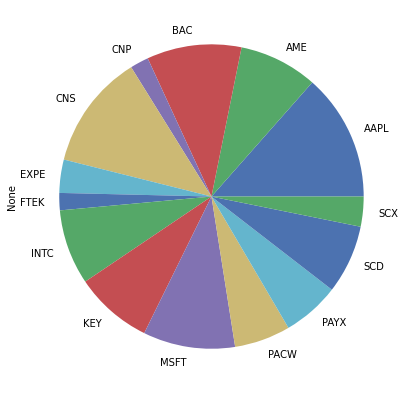

In [75]:
pd.Series(weights_3).plot.pie(figsize=(20,7))

#### Portafolio 3: Número de acciones a comprar con 100,000 USD

In [76]:
da_3 = pypfopt.discrete_allocation.DiscreteAllocation(weights_3, close_prices_train.iloc[-1], total_portfolio_value=100000)
alloc_3, leftover3 = da_3.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc_3

Leftover: $0.16


{'AAPL': 342,
 'AME': 123,
 'BAC': 408,
 'CNP': 70,
 'CNS': 357,
 'EXPE': 31,
 'FTEK': 1541,
 'INTC': 170,
 'KEY': 560,
 'MSFT': 96,
 'PACW': 179,
 'PAYX': 94,
 'SCD': 684,
 'SCX': 609}

In [77]:
shares_3 = pd.DataFrame.from_dict(list(alloc_3.items()))
shares_3 = shares_3.rename(columns={0:'symbol', 1:'shares'})

ticker_alloc_3 = shares_3['symbol'].values
ticker_alloc_3 = ticker_alloc_3.tolist()

shares_T3 = shares_3.set_index("symbol")
shares_T3 = shares_T3.T
shares_T3

symbol,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
shares,342,123,408,70,357,31,1541,170,560,96,179,94,684,609


In [78]:
ef_3.portfolio_performance(verbose=True)

Expected annual return: 38.3%
Annual volatility: 20.1%
Sharpe Ratio: 1.80


(0.38337522036198024, 0.20145175285265002, 1.8037828671948444)

#### Comportamiento Previsto Portafolio 3

In [79]:
future_portafolio_alloc3 = close_prices_pred[ticker_w3]
future_portafolio_alloc3

,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
date,,,,,,,,,,,,,,
2019-01-02,39.480000,67.489998,24.959999,28.000000,34.419998,111.980003,1.25,47.080002,15.020000,101.120003,33.490002,65.070000,11.02,5.56
2019-01-03,35.547501,65.570000,24.559999,28.160000,34.439999,108.519997,1.19,44.490002,15.070000,97.400002,33.169998,63.970001,10.82,5.52
2019-01-04,37.064999,68.050003,25.580000,28.680000,35.540001,113.089996,1.27,47.220001,15.580000,101.930000,34.330002,66.199997,11.20,5.70
2019-01-07,36.982498,67.940002,25.559999,28.790001,35.740002,114.559998,1.20,47.439999,15.740000,102.059998,34.650002,65.849998,11.48,5.65
2019-01-08,37.687500,68.940002,25.510000,29.340000,36.099998,116.970001,1.27,47.740002,15.730000,102.800003,35.259998,66.349998,11.70,5.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.067497,99.709999,35.220001,26.760000,62.650002,108.769997,0.87,59.410000,20.350000,157.380005,38.720001,84.650002,15.31,5.72
2019-12-26,72.477501,100.070000,35.520000,26.910000,62.830002,109.070000,0.87,59.820000,20.370001,158.669998,38.660000,84.709999,15.23,5.70
2019-12-27,72.449997,99.949997,35.349998,26.910000,62.660000,108.320000,0.86,60.080002,20.280001,158.960007,38.299999,85.120003,14.99,5.70


Text(0, 0.5, 'price in $')

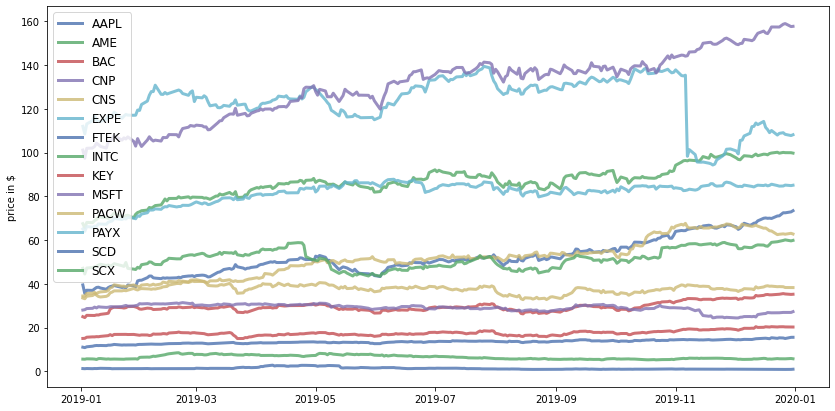

In [80]:
#Seleccionamos los precios de 2019 de las acciones del portafolio formado
future_prices_portfolio3 = close_prices_pred[ticker_alloc_3]
future_prices_portfolio3

##Graficamos los precios
plt.figure(figsize=(14, 7))
for c in future_prices_portfolio3.columns.values:
    plt.plot(future_prices_portfolio3.index, future_prices_portfolio3[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

C:\Users\alanf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


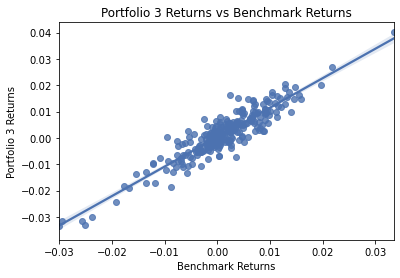

In [81]:
ret_stocks3 = future_portafolio_alloc3.pct_change()[1:]
port_ret3 = (ret_stocks3 * w3_v).sum(axis = 1)
port_ret3 = pd.DataFrame(port_ret3)
port_ret3.index = pd.to_datetime(port_ret3.index, format = '%Y-%m-%d')
port_ret3 = port_ret3.rename(columns={0: 'port3_returns'})
port_ret3

data3 = pd.concat([benchmark_ret, port_ret3], axis=1)

sns.regplot(benchmark_ret.values, port_ret3.values)
plt.xlabel("Benchmark Returns")
plt.ylabel("Portfolio 3 Returns")
plt.title("Portfolio 3 Returns vs Benchmark Returns")
plt.show()

In [82]:
covariance_matrix3 = data3[["SP500_returns","port3_returns"]].cov()
covariance_coefficient3 = covariance_matrix3.iloc[0,1]
benchmark_variance3 = data3["SP500_returns"].var()
portfolio_beta3 = covariance_coefficient3 / benchmark_variance3
portfolio_beta3

1.1184026666641234

In [83]:
portafolio_value3 = future_prices_portfolio3.multiply(np.array(shares_T3), axis='columns')
portafolio_value3['value_port3'] = portafolio_value3.sum(axis=1)
portafolio_value3 = portafolio_value3.drop(columns=ticker_alloc_3)
portafolio_value3['Portfolio 3 Daily Returns'] = portafolio_value3["value_port3"].pct_change()
portafolio_value3['Log Portfolio 3 Daily Returns'] = np.log(portafolio_value3.value_port3) - np.log(portafolio_value3.value_port3.shift(1))
portafolio_value3['Portfolio 3 Cumulative Returns'] = (1 + portafolio_value3['Portfolio 3 Daily Returns']).cumprod() - 1
portafolio_value3 = portafolio_value3.fillna(0)
portafolio_value3[["Portfolio 3 Daily Returns", "Log Portfolio 3 Daily Returns", "Portfolio 3 Cumulative Returns"]] = portafolio_value3[["Portfolio 3 Daily Returns", "Log Portfolio 3 Daily Returns", "Portfolio 3 Cumulative Returns"]].astype(np.float64)
portafolio_value3

,value_port3,Portfolio 3 Daily Returns,Log Portfolio 3 Daily Returns,Portfolio 3 Cumulative Returns
date,,,,
2019-01-02,100790.009711,0.000000,0.000000,0.000000
2019-01-03,97773.094752,-0.029933,-0.030390,-0.029933
2019-01-04,101678.710506,0.039946,0.039169,0.008817
2019-01-07,101970.534684,0.002870,0.002866,0.011713
2019-01-08,103044.324645,0.010530,0.010475,0.022366
...,...,...,...,...
2019-12-24,145338.645727,0.001969,0.001967,0.441995
2019-12-26,146204.346330,0.005956,0.005939,0.450584
2019-12-27,145843.049464,-0.002471,-0.002474,0.446999


Text(0, 0.5, 'Returns %')

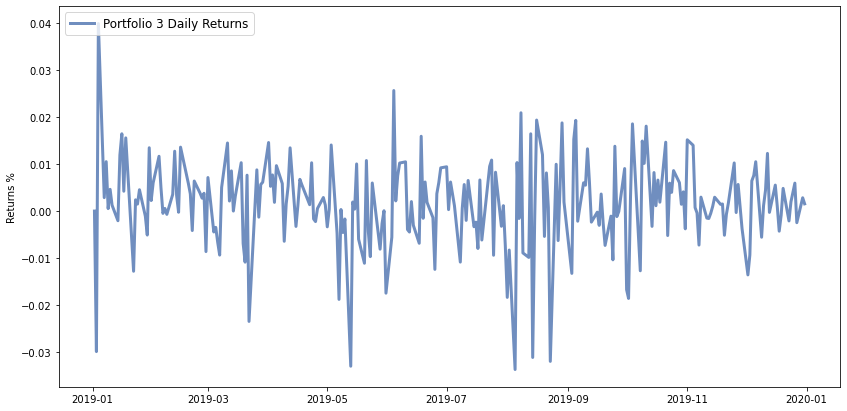

In [84]:
##Graficamos los retornos
plt.figure(figsize=(14, 7))
for c in portafolio_value3.columns.values[1:2]:
    plt.plot(portafolio_value3.index, portafolio_value3[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Returns %')

Start date,2019-01-02
End date,2019-12-31
Total months,12
,Backtest
Annual return,45.3%
Cumulative returns,45.3%
Annual volatility,15.1%
Sharpe ratio,2.55
Calmar ratio,4.79
Stability,0.81
Max drawdown,-9.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.47,2019-05-03,2019-06-03,2019-10-11,116
1,3.35,2019-03-18,2019-03-22,2019-04-01,11
2,2.99,2019-01-02,2019-01-03,2019-01-04,3
3,2.64,2019-11-27,2019-12-03,2019-12-12,12
4,2.53,2019-02-27,2019-03-07,2019-03-13,11


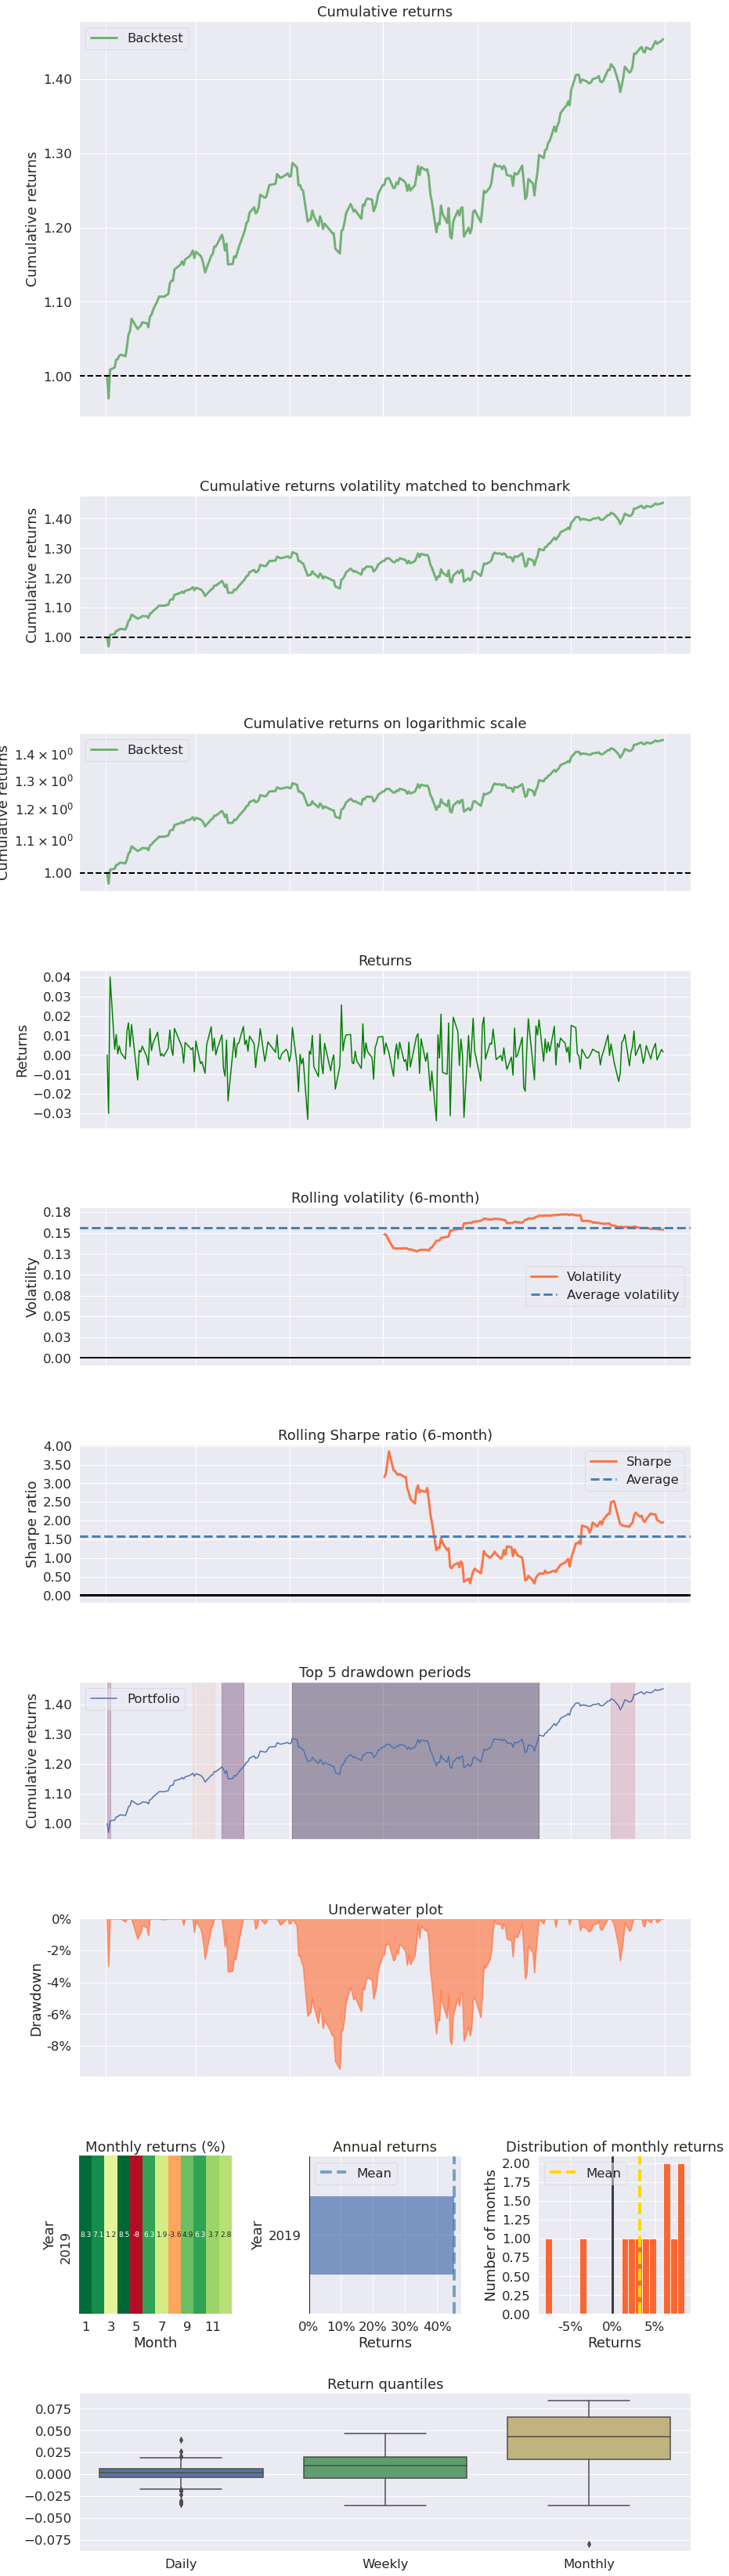

In [85]:
pf.create_returns_tear_sheet(portafolio_value3['Portfolio 3 Daily Returns'])

In [86]:
#metrics = [
#    'Rendimiento Anualizado',
#    'Rendimiento Acumulado',
#    'Rendimiento Ajustado por Riesgo de Modigliani',
#    'Volatilidad Anual',
#    'Sharpe Ratio',
#    'Treynor Ratio',
#    'Jensen-Alpha Ratio']
columns = ['Portfolio 3']
# Establecer un dataframe para los indicadores del portafolio
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)


#Rendimiento Acumulado
portfolio_evaluation_df.loc['Rendimiento Acumulado'] = portafolio_value3['Portfolio 3 Cumulative Returns'][-1]

#Rendimiento Anualizado
portfolio_evaluation_df.loc['Rendimiento Anualizado'] = (
    portafolio_value3['Portfolio 3 Daily Returns'].mean() * 252
)
#Volatilidad Anual
portfolio_evaluation_df.loc['Volatilidad Anual'] = (
    portafolio_value3['Portfolio 3 Daily Returns'].std() * np.sqrt(252)
)
#Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    portafolio_value3['Portfolio 3 Daily Returns'].mean() * 252) / (
    portafolio_value3['Portfolio 3 Daily Returns'].std() * np.sqrt(252)
)
#Treynor Ratio
portfolio_evaluation_df.loc['Treynor Ratio'] = (((
    portafolio_value3['Portfolio 3 Daily Returns'].mean() * 252)- rf) / portfolio_beta3)
#Rendimiento Ajustado por Riesgo de Modigliani
portfolio_evaluation_df.loc['Rendimiento Ajustado por Riesgo de Modigliani'] = (
    rf + ((portafolio_value3['Portfolio 3 Daily Returns'].mean() * 252) - rf) * (benchmark_ret['SP500_returns'].std()/portafolio_value3['Portfolio 3 Daily Returns'].std()) 
) 
#Jensen-Alpha Ratio
portfolio_evaluation_df.loc['Jensen-Alpha Ratio'] = ((
    (portafolio_value3['Portfolio 3 Daily Returns'].mean() * 252)- rf) - (
    (benchmark_ret['SP500_returns'].mean() * 252)- rf) * portfolio_beta3
)

portfolio_evaluation_df

,Portfolio 3
Rendimiento Anualizado,0.385528
Rendimiento Acumulado,0.453341
Rendimiento Ajustado por Riesgo de Modigliani,0.324057
Volatilidad Anual,0.151026
Sharpe Ratio,2.55272
Treynor Ratio,0.323401
Jensen-Alpha Ratio,0.0754615


### Modelo 4: Expectativas con RNN

In [87]:
bl_4 = BlackLittermanModel(S, pi=market_prior, absolute_views=views_4, risk_aversion=1, risk_free_rate=rf)

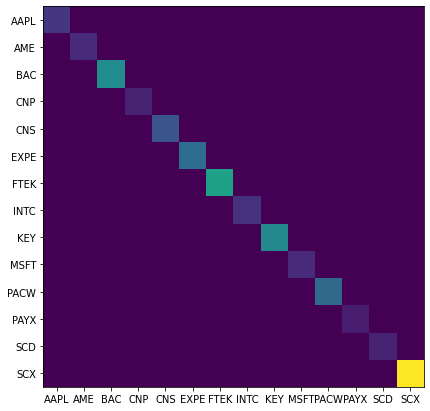

In [88]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl_4.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl_4.tickers)))
ax.set_yticks(np.arange(len(bl_4.tickers)))
bl_4 = BlackLittermanModel(S, pi=market_prior, absolute_views=views_4, risk_aversion=1, risk_free_rate=rf)
ax.set_xticklabels(bl_4.tickers)
ax.set_yticklabels(bl_4.tickers)
plt.show()

In [89]:
np.diag(bl_4.omega)

array([0.00233688, 0.00182512, 0.00716818, 0.00143091, 0.003849  ,
       0.00526062, 0.00839809, 0.00208723, 0.00689756, 0.00180223,
       0.00510138, 0.00119388, 0.00144485, 0.01468048])

In [90]:
ret_bl_4 = bl_4.bl_returns()
ret_bl_4

AAPL    0.463367
AME     0.326763
BAC     0.464993
CNP     0.129500
CNS     0.476574
EXPE    0.223229
FTEK    0.194169
INTC    0.316798
KEY     0.410109
MSFT    0.358531
PACW    0.323404
PAYX    0.246912
SCD     0.283717
SCX     0.235758
dtype: float64

In [91]:
rets_df_4 = pd.DataFrame([market_prior, ret_bl_4, pd.Series(views_4)], 
             index=["Retornos implícitos", "Retornos Posteriores", "Expectativa de Retorno"]).T
rets_df_4

,Retornos implícitos,Retornos Posteriores,Expectativa de Retorno
AAPL,0.078055,0.463367,0.805234
AME,0.062993,0.326763,0.454210
BAC,0.110774,0.464993,0.407650
CNP,0.051077,0.129500,-0.042704
CNS,0.077223,0.476574,0.822432
EXPE,0.079137,0.223229,-0.040227
FTEK,0.090976,0.194169,-0.235306
INTC,0.070510,0.316798,0.255850
KEY,0.100886,0.410109,0.360398
MSFT,0.071374,0.358531,0.523921


<AxesSubplot:>

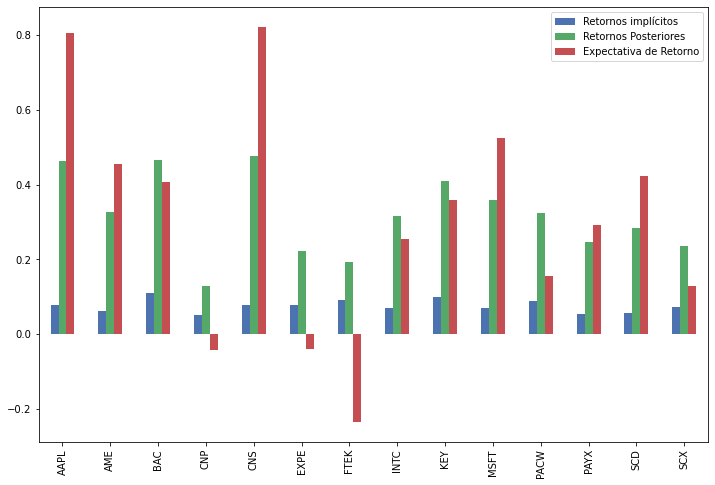

In [92]:
rets_df_4.plot.bar(figsize=(12,8))

<AxesSubplot:>

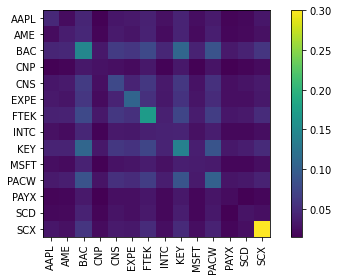

In [93]:
S_bl_4 = bl_4.bl_cov()
plotting.plot_covariance(S_bl_4)

#### Asignación de pesos (w) del portafolio 4

In [94]:
ef_4 = EfficientFrontier(ret_bl_4, S_bl_4)
ef_4.add_objective(objective_functions.L2_reg)
ef_4.max_sharpe()
weights_4 = ef_4.clean_weights()
weights_4

C:\Users\alanf\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:247: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.13324),
             ('AME', 0.08375),
             ('BAC', 0.10108),
             ('CNP', 0.0181),
             ('CNS', 0.12583),
             ('EXPE', 0.03461),
             ('FTEK', 0.01283),
             ('INTC', 0.07915),
             ('KEY', 0.08388),
             ('MSFT', 0.09723),
             ('PACW', 0.06099),
             ('PAYX', 0.06089),
             ('SCD', 0.07188),
             ('SCX', 0.03654)])

In [95]:
shares_4 = pd.DataFrame.from_dict(list(weights_4.items()))
shares_4 = shares_4.rename(columns={0:'symbol', 1:'w'})
#shares_4_csv = shares_3.to_csv("C:/Users/alanf/Desktop/work_2021/ModeloBL_Programacion/Modelo_VF/datasets/portafolio4_pesos.csv")

w4_v = shares_4['w'].values
w4_v = w4_v.tolist()

ticker_w4 = shares_4['symbol'].values
ticker_w4 = ticker_w4.tolist()
ticker_w4

shares_4

,symbol,w
0,AAPL,0.13324
1,AME,0.08375
2,BAC,0.10108
3,CNP,0.01810
4,CNS,0.12583
5,EXPE,0.03461
6,FTEK,0.01283
7,INTC,0.07915
8,KEY,0.08388
9,MSFT,0.09723


<AxesSubplot:ylabel='None'>

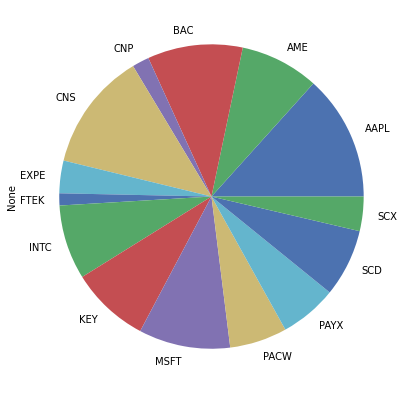

In [96]:
pd.Series(weights_4).plot.pie(figsize=(20,7))

#### Portafolio 4: Número de acciones a comprar con 100,000 USD

In [97]:
da_4 = pypfopt.discrete_allocation.DiscreteAllocation(weights_4, close_prices_train.iloc[-1], total_portfolio_value=100000)
alloc_4, leftover3 = da_4.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc_4

Leftover: $0.16


{'AAPL': 338,
 'AME': 124,
 'BAC': 410,
 'CNP': 64,
 'CNS': 367,
 'EXPE': 31,
 'FTEK': 1073,
 'INTC': 168,
 'KEY': 567,
 'MSFT': 96,
 'PACW': 183,
 'PAYX': 93,
 'SCD': 673,
 'SCX': 698}

In [98]:
shares_4 = pd.DataFrame.from_dict(list(alloc_4.items()))
shares_4 = shares_4.rename(columns={0:'symbol', 1:'shares'})

ticker_alloc_4 = shares_4['symbol'].values
ticker_alloc_4 = ticker_alloc_4.tolist()

shares_T4 = shares_4.set_index("symbol")
shares_T4 = shares_T4.T
shares_T4

symbol,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
shares,338,124,410,64,367,31,1073,168,567,96,183,93,673,698


In [99]:
ef_4.portfolio_performance(verbose=True)

Expected annual return: 36.7%
Annual volatility: 20.2%
Sharpe Ratio: 1.72


(0.36673526372205156, 0.2018557162655907, 1.7177381455268588)

#### Comportamiento Previsto Portafolio 4

In [100]:
future_portafolio_alloc4 = close_prices_pred[ticker_w4]
future_portafolio_alloc4

,AAPL,AME,BAC,CNP,CNS,EXPE,FTEK,INTC,KEY,MSFT,PACW,PAYX,SCD,SCX
date,,,,,,,,,,,,,,
2019-01-02,39.480000,67.489998,24.959999,28.000000,34.419998,111.980003,1.25,47.080002,15.020000,101.120003,33.490002,65.070000,11.02,5.56
2019-01-03,35.547501,65.570000,24.559999,28.160000,34.439999,108.519997,1.19,44.490002,15.070000,97.400002,33.169998,63.970001,10.82,5.52
2019-01-04,37.064999,68.050003,25.580000,28.680000,35.540001,113.089996,1.27,47.220001,15.580000,101.930000,34.330002,66.199997,11.20,5.70
2019-01-07,36.982498,67.940002,25.559999,28.790001,35.740002,114.559998,1.20,47.439999,15.740000,102.059998,34.650002,65.849998,11.48,5.65
2019-01-08,37.687500,68.940002,25.510000,29.340000,36.099998,116.970001,1.27,47.740002,15.730000,102.800003,35.259998,66.349998,11.70,5.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.067497,99.709999,35.220001,26.760000,62.650002,108.769997,0.87,59.410000,20.350000,157.380005,38.720001,84.650002,15.31,5.72
2019-12-26,72.477501,100.070000,35.520000,26.910000,62.830002,109.070000,0.87,59.820000,20.370001,158.669998,38.660000,84.709999,15.23,5.70
2019-12-27,72.449997,99.949997,35.349998,26.910000,62.660000,108.320000,0.86,60.080002,20.280001,158.960007,38.299999,85.120003,14.99,5.70


Text(0, 0.5, 'price in $')

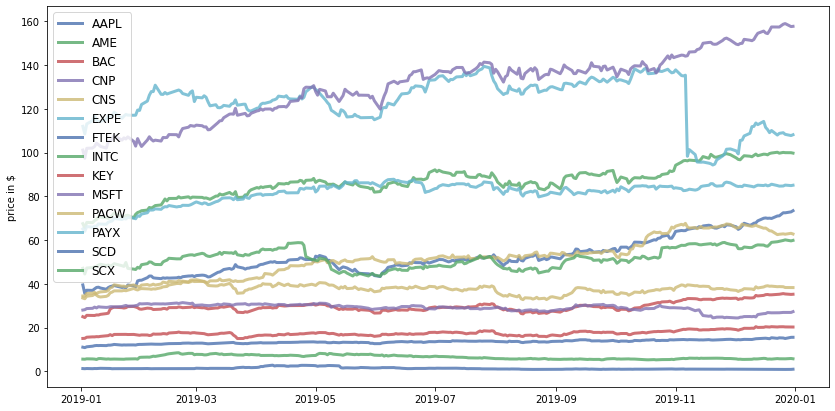

In [101]:
#Seleccionamos los precios de 2019 de las acciones del portafolio formado
future_prices_portfolio4 = close_prices_pred[ticker_alloc_4]
future_prices_portfolio4

##Graficamos los precios
plt.figure(figsize=(14, 7))
for c in future_prices_portfolio4.columns.values:
    plt.plot(future_prices_portfolio4.index, future_prices_portfolio4[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

C:\Users\alanf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


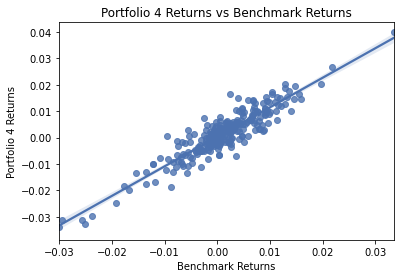

In [102]:
ret_stocks4 = future_portafolio_alloc4.pct_change()[1:]
port_ret4 = (ret_stocks4 * w4_v).sum(axis = 1)
port_ret4 = pd.DataFrame(port_ret4)
port_ret4.index = pd.to_datetime(port_ret4.index, format = '%Y-%m-%d')
port_ret4 = port_ret4.rename(columns={0: 'port4_returns'})
port_ret4

data4 = pd.concat([benchmark_ret, port_ret4], axis=1)

sns.regplot(benchmark_ret.values, port_ret4.values)
plt.xlabel("Benchmark Returns")
plt.ylabel("Portfolio 4 Returns")
plt.title("Portfolio 4 Returns vs Benchmark Returns")
plt.show()

In [103]:
covariance_matrix4 = data4[["SP500_returns","port4_returns"]].cov()
covariance_coefficient4 = covariance_matrix4.iloc[0,1]
benchmark_variance4 = data4["SP500_returns"].var()
portfolio_beta4 = covariance_coefficient4 / benchmark_variance4
portfolio_beta4

1.1181352196986039

In [104]:
portafolio_value4 = future_prices_portfolio4.multiply(np.array(shares_T4), axis='columns')
portafolio_value4['value_port4'] = portafolio_value4.sum(axis=1)
portafolio_value4 = portafolio_value4.drop(columns=ticker_alloc_4)
portafolio_value4['Portfolio 4 Daily Returns'] = portafolio_value4["value_port4"].pct_change()
portafolio_value4['Log Portfolio 4 Daily Returns'] = np.log(portafolio_value4.value_port4) - np.log(portafolio_value4.value_port4.shift(1))
portafolio_value4['Portfolio 4 Cumulative Returns'] = (1 + portafolio_value4['Portfolio 4 Daily Returns']).cumprod() - 1
portafolio_value4 = portafolio_value4.fillna(0)
portafolio_value4[["Portfolio 4 Daily Returns", "Log Portfolio 4 Daily Returns", "Portfolio 4 Cumulative Returns"]] = portafolio_value4[["Portfolio 4 Daily Returns", "Log Portfolio 4 Daily Returns", "Portfolio 4 Cumulative Returns"]].astype(np.float64)
portafolio_value4

,value_port4,Portfolio 4 Daily Returns,Log Portfolio 4 Daily Returns,Portfolio 4 Cumulative Returns
date,,,,
2019-01-02,100794.189691,0.000000,0.000000,0.000000
2019-01-03,97821.594723,-0.029492,-0.029935,-0.029492
2019-01-04,101708.460532,0.039734,0.038965,0.009071
2019-01-07,102029.344718,0.003155,0.003150,0.012254
2019-01-08,103061.374617,0.010115,0.010064,0.022493
...,...,...,...,...
2019-12-24,145717.835762,0.001838,0.001837,0.445697
2019-12-26,146577.876354,0.005902,0.005885,0.454229
2019-12-27,146218.849465,-0.002449,-0.002452,0.450667


Text(0, 0.5, 'Returns %')

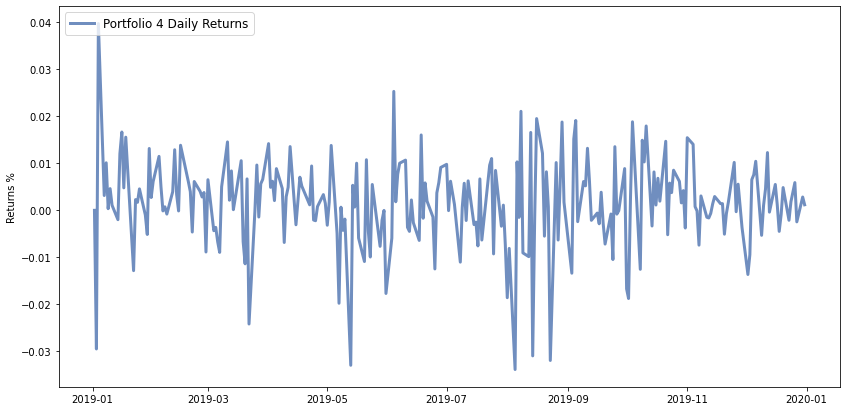

In [105]:
##Graficamos los retornos
plt.figure(figsize=(14, 7))
for c in portafolio_value4.columns.values[1:2]:
    plt.plot(portafolio_value4.index, portafolio_value4[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Returns %')

Start date,2019-01-02
End date,2019-12-31
Total months,12
,Backtest
Annual return,45.6%
Cumulative returns,45.6%
Annual volatility,15.1%
Sharpe ratio,2.57
Calmar ratio,4.96
Stability,0.81
Max drawdown,-9.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.20,2019-05-03,2019-06-03,2019-07-24,59
1,7.53,2019-07-24,2019-08-15,2019-09-12,37
2,3.66,2019-09-12,2019-10-02,2019-10-11,22
3,3.55,2019-03-18,2019-03-25,2019-04-02,12
4,2.95,2019-01-02,2019-01-03,2019-01-04,3


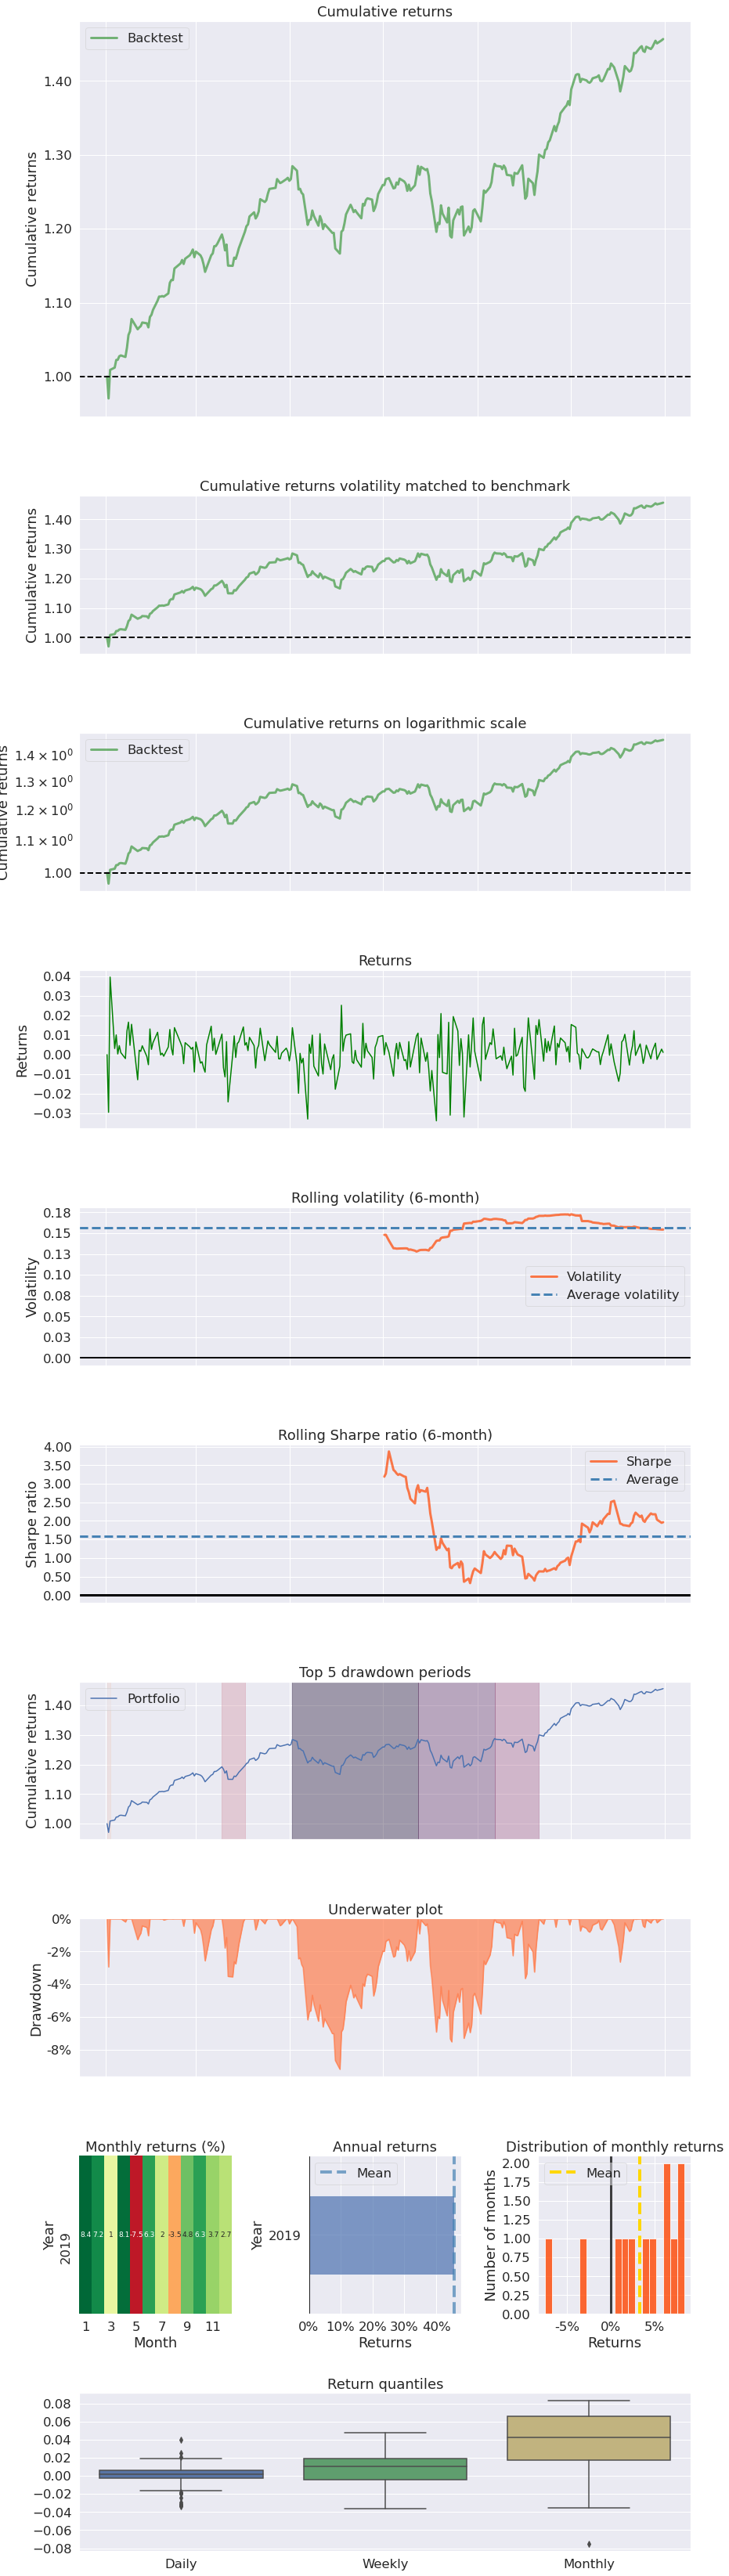

In [106]:
pf.create_returns_tear_sheet(portafolio_value4['Portfolio 4 Daily Returns'])

In [108]:
#metrics = [
#    'Rendimiento Anualizado',
#    'Rendimiento Acumulado',
#    'Rendimiento Ajustado por Riesgo de Modigliani',
#    'Volatilidad Anual',
#    'Sharpe Ratio',
#    'Treynor Ratio',
#    'Jensen-Alpha Ratio']
columns = ['Portfolio 4']
# Establecer un dataframe para los indicadores del portafolio
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)


#Rendimiento Acumulado
portfolio_evaluation_df.loc['Rendimiento Acumulado'] = portafolio_value4['Portfolio 4 Cumulative Returns'][-1]

#Rendimiento Anualizado
portfolio_evaluation_df.loc['Rendimiento Anualizado'] = (
    portafolio_value4['Portfolio 4 Daily Returns'].mean() * 252
)
#Volatilidad Anual
portfolio_evaluation_df.loc['Volatilidad Anual'] = (
    portafolio_value4['Portfolio 4 Daily Returns'].std() * np.sqrt(252)
)
#Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    portafolio_value4['Portfolio 4 Daily Returns'].mean() * 252) / (
    portafolio_value4['Portfolio 4 Daily Returns'].std() * np.sqrt(252)
)
#Treynor Ratio
portfolio_evaluation_df.loc['Treynor Ratio'] = (((
    portafolio_value4['Portfolio 4 Daily Returns'].mean() * 252)- rf) / portfolio_beta4)
#Rendimiento Ajustado por Riesgo de Modigliani
portfolio_evaluation_df.loc['Rendimiento Ajustado por Riesgo de Modigliani'] = (
    rf + ((portafolio_value4['Portfolio 4 Daily Returns'].mean() * 252) - rf) * (benchmark_ret['SP500_returns'].std()/portafolio_value4['Portfolio 4 Daily Returns'].std()) 
) 
#Jensen-Alpha Ratio
portfolio_evaluation_df.loc['Jensen-Alpha Ratio'] = ((
    (portafolio_value4['Portfolio 4 Daily Returns'].mean() * 252)- rf) - (
    (benchmark_ret['SP500_returns'].mean() * 252)- rf) * portfolio_beta4
)

portfolio_evaluation_df

,Portfolio 4
Rendimiento Anualizado,0.387688
Rendimiento Acumulado,0.456496
Rendimiento Ajustado por Riesgo de Modigliani,0.326009
Volatilidad Anual,0.150947
Sharpe Ratio,2.56837
Treynor Ratio,0.325411
Jensen-Alpha Ratio,0.0776906
